In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 8vaux52z


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 1/1186 [00:01<32:12,  1.63s/it]

  0%|▏                                                                                                                                                  | 2/1186 [00:01<15:14,  1.30it/s]

  0%|▎                                                                                                                                                  | 3/1186 [00:01<09:48,  2.01it/s]

  0%|▍                                                                                                                                                  | 4/1186 [00:02<07:15,  2.72it/s]

  0%|▌                                                                                                                                                  | 5/1186 [00:02<05:50,  3.37it/s]

  1%|▋                                                                                                                                                  | 6/1186 [00:02<04:59,  3.94it/s]

  1%|▊                                                                                                                                                  | 7/1186 [00:02<04:26,  4.42it/s]

  1%|▉                                                                                                                                                  | 8/1186 [00:02<04:05,  4.80it/s]

  1%|█                                                                                                                                                  | 9/1186 [00:02<03:51,  5.09it/s]

  1%|█▏                                                                                                                                                | 10/1186 [00:03<03:41,  5.31it/s]

  1%|█▎                                                                                                                                                | 11/1186 [00:03<03:34,  5.47it/s]

  1%|█▍                                                                                                                                                | 12/1186 [00:03<03:30,  5.58it/s]

  1%|█▌                                                                                                                                                | 13/1186 [00:03<03:26,  5.67it/s]

  1%|█▋                                                                                                                                                | 14/1186 [00:03<03:24,  5.72it/s]

  1%|█▊                                                                                                                                                | 15/1186 [00:04<03:23,  5.76it/s]

  1%|█▉                                                                                                                                                | 16/1186 [00:04<03:21,  5.80it/s]

  1%|██                                                                                                                                                | 17/1186 [00:04<03:20,  5.82it/s]

  2%|██▏                                                                                                                                               | 18/1186 [00:04<03:20,  5.84it/s]

  2%|██▎                                                                                                                                               | 19/1186 [00:04<03:19,  5.85it/s]

  2%|██▍                                                                                                                                               | 20/1186 [00:04<03:18,  5.86it/s]

  2%|██▌                                                                                                                                               | 21/1186 [00:05<03:18,  5.87it/s]

  2%|██▋                                                                                                                                               | 22/1186 [00:05<03:18,  5.87it/s]

  2%|██▊                                                                                                                                               | 23/1186 [00:05<03:18,  5.87it/s]

  2%|██▉                                                                                                                                               | 24/1186 [00:05<03:17,  5.87it/s]

  2%|███                                                                                                                                               | 25/1186 [00:05<03:17,  5.87it/s]

  2%|███▏                                                                                                                                              | 26/1186 [00:05<03:17,  5.87it/s]

  2%|███▎                                                                                                                                              | 27/1186 [00:06<03:17,  5.87it/s]

  2%|███▍                                                                                                                                              | 28/1186 [00:06<03:17,  5.87it/s]

  2%|███▌                                                                                                                                              | 29/1186 [00:06<03:17,  5.87it/s]

  3%|███▋                                                                                                                                              | 30/1186 [00:06<03:17,  5.86it/s]

  3%|███▊                                                                                                                                              | 31/1186 [00:06<03:16,  5.86it/s]

  3%|███▉                                                                                                                                              | 32/1186 [00:06<03:16,  5.87it/s]

  3%|████                                                                                                                                              | 33/1186 [00:07<03:16,  5.87it/s]

  3%|████▏                                                                                                                                             | 34/1186 [00:07<03:16,  5.87it/s]

  3%|████▎                                                                                                                                             | 35/1186 [00:07<03:16,  5.87it/s]

  3%|████▍                                                                                                                                             | 36/1186 [00:07<03:15,  5.87it/s]

  3%|████▌                                                                                                                                             | 37/1186 [00:07<03:15,  5.87it/s]

  3%|████▋                                                                                                                                             | 38/1186 [00:07<03:15,  5.87it/s]

  3%|████▊                                                                                                                                             | 39/1186 [00:08<03:15,  5.86it/s]

  3%|████▉                                                                                                                                             | 40/1186 [00:08<03:15,  5.86it/s]

  3%|█████                                                                                                                                             | 41/1186 [00:08<03:15,  5.87it/s]

  4%|█████▏                                                                                                                                            | 42/1186 [00:08<03:14,  5.87it/s]

  4%|█████▎                                                                                                                                            | 43/1186 [00:08<03:14,  5.87it/s]

  4%|█████▍                                                                                                                                            | 44/1186 [00:08<03:14,  5.87it/s]

  4%|█████▌                                                                                                                                            | 45/1186 [00:09<03:14,  5.87it/s]

  4%|█████▋                                                                                                                                            | 46/1186 [00:09<03:14,  5.86it/s]

  4%|█████▊                                                                                                                                            | 47/1186 [00:09<03:14,  5.86it/s]

  4%|█████▉                                                                                                                                            | 48/1186 [00:09<03:13,  5.87it/s]

  4%|██████                                                                                                                                            | 49/1186 [00:09<03:13,  5.87it/s]

  4%|██████▏                                                                                                                                           | 50/1186 [00:09<03:13,  5.87it/s]

  4%|██████▎                                                                                                                                           | 51/1186 [00:10<03:13,  5.87it/s]

  4%|██████▍                                                                                                                                           | 52/1186 [00:10<03:13,  5.87it/s]

  4%|██████▌                                                                                                                                           | 53/1186 [00:10<03:13,  5.87it/s]

  5%|██████▋                                                                                                                                           | 54/1186 [00:10<03:12,  5.88it/s]

  5%|██████▊                                                                                                                                           | 55/1186 [00:10<03:12,  5.89it/s]

  5%|██████▉                                                                                                                                           | 56/1186 [00:10<03:11,  5.89it/s]

  5%|███████                                                                                                                                           | 57/1186 [00:11<03:11,  5.90it/s]

  5%|███████▏                                                                                                                                          | 58/1186 [00:11<03:11,  5.90it/s]

  5%|███████▎                                                                                                                                          | 59/1186 [00:11<03:10,  5.90it/s]

  5%|███████▍                                                                                                                                          | 60/1186 [00:11<03:10,  5.90it/s]

  5%|███████▌                                                                                                                                          | 61/1186 [00:11<03:10,  5.89it/s]

  5%|███████▋                                                                                                                                          | 62/1186 [00:12<03:10,  5.88it/s]

  5%|███████▊                                                                                                                                          | 63/1186 [00:12<03:10,  5.88it/s]

  5%|███████▉                                                                                                                                          | 64/1186 [00:12<03:10,  5.88it/s]

  5%|████████                                                                                                                                          | 65/1186 [00:12<03:10,  5.87it/s]

  6%|████████                                                                                                                                          | 66/1186 [00:12<03:10,  5.87it/s]

  6%|████████▏                                                                                                                                         | 67/1186 [00:12<03:10,  5.86it/s]

  6%|████████▎                                                                                                                                         | 68/1186 [00:13<03:10,  5.86it/s]

  6%|████████▍                                                                                                                                         | 69/1186 [00:13<03:10,  5.86it/s]

  6%|████████▌                                                                                                                                         | 70/1186 [00:13<03:10,  5.86it/s]

  6%|████████▋                                                                                                                                         | 71/1186 [00:13<03:10,  5.87it/s]

  6%|████████▊                                                                                                                                         | 72/1186 [00:13<03:10,  5.86it/s]

  6%|████████▉                                                                                                                                         | 73/1186 [00:13<03:09,  5.86it/s]

  6%|█████████                                                                                                                                         | 74/1186 [00:14<03:09,  5.86it/s]

  6%|█████████▏                                                                                                                                        | 75/1186 [00:14<03:09,  5.86it/s]

  6%|█████████▎                                                                                                                                        | 76/1186 [00:14<03:09,  5.86it/s]

  6%|█████████▍                                                                                                                                        | 77/1186 [00:14<03:09,  5.86it/s]

  7%|█████████▌                                                                                                                                        | 78/1186 [00:14<03:08,  5.86it/s]

  7%|█████████▋                                                                                                                                        | 79/1186 [00:14<03:08,  5.87it/s]

  7%|█████████▊                                                                                                                                        | 80/1186 [00:15<03:08,  5.87it/s]

  7%|█████████▉                                                                                                                                        | 81/1186 [00:15<03:08,  5.86it/s]

  7%|██████████                                                                                                                                        | 82/1186 [00:15<03:08,  5.86it/s]

  7%|██████████▏                                                                                                                                       | 83/1186 [00:15<03:08,  5.86it/s]

  7%|██████████▎                                                                                                                                       | 84/1186 [00:15<03:07,  5.86it/s]

  7%|██████████▍                                                                                                                                       | 85/1186 [00:15<03:07,  5.87it/s]

  7%|██████████▌                                                                                                                                       | 86/1186 [00:16<03:07,  5.87it/s]

  7%|██████████▋                                                                                                                                       | 87/1186 [00:16<03:07,  5.87it/s]

  7%|██████████▊                                                                                                                                       | 88/1186 [00:16<03:07,  5.86it/s]

  8%|██████████▉                                                                                                                                       | 89/1186 [00:16<03:07,  5.86it/s]

  8%|███████████                                                                                                                                       | 90/1186 [00:16<03:06,  5.87it/s]

  8%|███████████▏                                                                                                                                      | 91/1186 [00:16<03:06,  5.87it/s]

  8%|███████████▎                                                                                                                                      | 92/1186 [00:17<03:06,  5.87it/s]

  8%|███████████▍                                                                                                                                      | 93/1186 [00:17<03:06,  5.87it/s]

  8%|███████████▌                                                                                                                                      | 94/1186 [00:17<03:06,  5.87it/s]

  8%|███████████▋                                                                                                                                      | 95/1186 [00:17<03:06,  5.86it/s]

  8%|███████████▊                                                                                                                                      | 96/1186 [00:17<03:05,  5.87it/s]

  8%|███████████▉                                                                                                                                      | 97/1186 [00:17<03:05,  5.87it/s]

  8%|████████████                                                                                                                                      | 98/1186 [00:18<03:05,  5.87it/s]

  8%|████████████▏                                                                                                                                     | 99/1186 [00:18<03:05,  5.87it/s]

  8%|████████████▏                                                                                                                                    | 100/1186 [00:18<03:04,  5.87it/s]

  9%|████████████▎                                                                                                                                    | 101/1186 [00:18<03:04,  5.87it/s]

  9%|████████████▍                                                                                                                                    | 102/1186 [00:18<03:04,  5.86it/s]

  9%|████████████▌                                                                                                                                    | 103/1186 [00:19<03:04,  5.87it/s]

  9%|████████████▋                                                                                                                                    | 104/1186 [00:19<03:04,  5.87it/s]

  9%|████████████▊                                                                                                                                    | 105/1186 [00:19<03:04,  5.87it/s]

  9%|████████████▉                                                                                                                                    | 106/1186 [00:19<03:04,  5.87it/s]

  9%|█████████████                                                                                                                                    | 107/1186 [00:19<03:03,  5.87it/s]

  9%|█████████████▏                                                                                                                                   | 108/1186 [00:19<03:03,  5.87it/s]

  9%|█████████████▎                                                                                                                                   | 109/1186 [00:20<03:03,  5.87it/s]

  9%|█████████████▍                                                                                                                                   | 110/1186 [00:20<03:02,  5.88it/s]

  9%|█████████████▌                                                                                                                                   | 111/1186 [00:20<03:02,  5.89it/s]

  9%|█████████████▋                                                                                                                                   | 112/1186 [00:20<03:02,  5.90it/s]

 10%|█████████████▊                                                                                                                                   | 113/1186 [00:20<03:01,  5.90it/s]

 10%|█████████████▉                                                                                                                                   | 114/1186 [00:20<03:01,  5.90it/s]

 10%|██████████████                                                                                                                                   | 115/1186 [00:21<03:01,  5.91it/s]

 10%|██████████████▏                                                                                                                                  | 116/1186 [00:21<03:01,  5.90it/s]

 10%|██████████████▎                                                                                                                                  | 117/1186 [00:21<03:01,  5.89it/s]

 10%|██████████████▍                                                                                                                                  | 118/1186 [00:21<03:01,  5.88it/s]

 10%|██████████████▌                                                                                                                                  | 119/1186 [00:21<03:01,  5.88it/s]

 10%|██████████████▋                                                                                                                                  | 120/1186 [00:21<03:01,  5.88it/s]

 10%|██████████████▊                                                                                                                                  | 121/1186 [00:22<03:01,  5.88it/s]

 10%|██████████████▉                                                                                                                                  | 122/1186 [00:22<03:01,  5.87it/s]

 10%|███████████████                                                                                                                                  | 123/1186 [00:22<03:01,  5.87it/s]

 10%|███████████████▏                                                                                                                                 | 124/1186 [00:22<03:00,  5.87it/s]

 11%|███████████████▎                                                                                                                                 | 125/1186 [00:22<03:00,  5.87it/s]

 11%|███████████████▍                                                                                                                                 | 126/1186 [00:22<03:00,  5.87it/s]

 11%|███████████████▌                                                                                                                                 | 127/1186 [00:23<03:00,  5.87it/s]

 11%|███████████████▋                                                                                                                                 | 128/1186 [00:23<03:00,  5.87it/s]

 11%|███████████████▊                                                                                                                                 | 129/1186 [00:23<03:00,  5.87it/s]

 11%|███████████████▉                                                                                                                                 | 130/1186 [00:23<03:00,  5.86it/s]

 11%|████████████████                                                                                                                                 | 131/1186 [00:23<02:59,  5.86it/s]

 11%|████████████████▏                                                                                                                                | 132/1186 [00:23<02:59,  5.87it/s]

 11%|████████████████▎                                                                                                                                | 133/1186 [00:24<02:59,  5.87it/s]

 11%|████████████████▍                                                                                                                                | 134/1186 [00:24<02:59,  5.87it/s]

 11%|████████████████▌                                                                                                                                | 135/1186 [00:24<02:59,  5.87it/s]

 11%|████████████████▋                                                                                                                                | 136/1186 [00:24<02:58,  5.87it/s]

 12%|████████████████▋                                                                                                                                | 137/1186 [00:24<02:58,  5.87it/s]

 12%|████████████████▊                                                                                                                                | 138/1186 [00:24<02:58,  5.87it/s]

 12%|████████████████▉                                                                                                                                | 139/1186 [00:25<02:58,  5.87it/s]

 12%|█████████████████                                                                                                                                | 140/1186 [00:25<02:58,  5.87it/s]

 12%|█████████████████▏                                                                                                                               | 141/1186 [00:25<02:58,  5.87it/s]

 12%|█████████████████▎                                                                                                                               | 142/1186 [00:25<02:57,  5.87it/s]

 12%|█████████████████▍                                                                                                                               | 143/1186 [00:25<02:57,  5.87it/s]

 12%|█████████████████▌                                                                                                                               | 144/1186 [00:25<02:57,  5.86it/s]

 12%|█████████████████▋                                                                                                                               | 145/1186 [00:26<02:57,  5.87it/s]

 12%|█████████████████▊                                                                                                                               | 146/1186 [00:26<02:57,  5.87it/s]

 12%|█████████████████▉                                                                                                                               | 147/1186 [00:26<02:57,  5.87it/s]

 12%|██████████████████                                                                                                                               | 148/1186 [00:26<02:56,  5.87it/s]

 13%|██████████████████▏                                                                                                                              | 149/1186 [00:26<02:56,  5.87it/s]

 13%|██████████████████▎                                                                                                                              | 150/1186 [00:27<02:56,  5.87it/s]

 13%|██████████████████▍                                                                                                                              | 151/1186 [00:27<02:56,  5.86it/s]

 13%|██████████████████▌                                                                                                                              | 152/1186 [00:27<02:56,  5.87it/s]

 13%|██████████████████▋                                                                                                                              | 153/1186 [00:27<02:56,  5.87it/s]

 13%|██████████████████▊                                                                                                                              | 154/1186 [00:27<02:55,  5.87it/s]

 13%|██████████████████▉                                                                                                                              | 155/1186 [00:27<02:55,  5.87it/s]

 13%|███████████████████                                                                                                                              | 156/1186 [00:28<02:55,  5.87it/s]

 13%|███████████████████▏                                                                                                                             | 157/1186 [00:28<02:55,  5.87it/s]

 13%|███████████████████▎                                                                                                                             | 158/1186 [00:28<02:55,  5.86it/s]

 13%|███████████████████▍                                                                                                                             | 159/1186 [00:28<02:55,  5.87it/s]

 13%|███████████████████▌                                                                                                                             | 160/1186 [00:28<02:54,  5.87it/s]

 14%|███████████████████▋                                                                                                                             | 161/1186 [00:28<02:54,  5.87it/s]

 14%|███████████████████▊                                                                                                                             | 162/1186 [00:29<02:54,  5.87it/s]

 14%|███████████████████▉                                                                                                                             | 163/1186 [00:29<02:54,  5.87it/s]

 14%|████████████████████                                                                                                                             | 164/1186 [00:29<02:54,  5.87it/s]

 14%|████████████████████▏                                                                                                                            | 165/1186 [00:29<02:53,  5.87it/s]

 14%|████████████████████▎                                                                                                                            | 166/1186 [00:29<02:53,  5.88it/s]

 14%|████████████████████▍                                                                                                                            | 167/1186 [00:29<02:53,  5.89it/s]

 14%|████████████████████▌                                                                                                                            | 168/1186 [00:30<02:52,  5.90it/s]

 14%|████████████████████▋                                                                                                                            | 169/1186 [00:30<02:52,  5.90it/s]

 14%|████████████████████▊                                                                                                                            | 170/1186 [00:30<02:52,  5.90it/s]

 14%|████████████████████▉                                                                                                                            | 171/1186 [00:30<02:51,  5.91it/s]

 15%|█████████████████████                                                                                                                            | 172/1186 [00:30<02:51,  5.90it/s]

 15%|█████████████████████▏                                                                                                                           | 173/1186 [00:30<02:51,  5.89it/s]

 15%|█████████████████████▎                                                                                                                           | 174/1186 [00:31<02:51,  5.88it/s]

 15%|█████████████████████▍                                                                                                                           | 175/1186 [00:31<02:51,  5.88it/s]

 15%|█████████████████████▌                                                                                                                           | 176/1186 [00:31<02:51,  5.88it/s]

 15%|█████████████████████▋                                                                                                                           | 177/1186 [00:31<02:51,  5.88it/s]

 15%|█████████████████████▊                                                                                                                           | 178/1186 [00:31<02:51,  5.87it/s]

 15%|█████████████████████▉                                                                                                                           | 179/1186 [00:31<02:51,  5.86it/s]

 15%|██████████████████████                                                                                                                           | 180/1186 [00:32<02:51,  5.87it/s]

 15%|██████████████████████▏                                                                                                                          | 181/1186 [00:32<02:51,  5.87it/s]

 15%|██████████████████████▎                                                                                                                          | 182/1186 [00:32<02:51,  5.87it/s]

 15%|██████████████████████▎                                                                                                                          | 183/1186 [00:32<02:50,  5.87it/s]

 16%|██████████████████████▍                                                                                                                          | 184/1186 [00:32<02:50,  5.87it/s]

 16%|██████████████████████▌                                                                                                                          | 185/1186 [00:32<02:50,  5.87it/s]

 16%|██████████████████████▋                                                                                                                          | 186/1186 [00:33<02:50,  5.86it/s]

 16%|██████████████████████▊                                                                                                                          | 187/1186 [00:33<02:50,  5.87it/s]

 16%|██████████████████████▉                                                                                                                          | 188/1186 [00:33<02:50,  5.87it/s]

 16%|███████████████████████                                                                                                                          | 189/1186 [00:33<02:49,  5.87it/s]

 16%|███████████████████████▏                                                                                                                         | 190/1186 [00:33<02:49,  5.87it/s]

 16%|███████████████████████▎                                                                                                                         | 191/1186 [00:33<02:49,  5.87it/s]

 16%|███████████████████████▍                                                                                                                         | 192/1186 [00:34<02:49,  5.87it/s]

 16%|███████████████████████▌                                                                                                                         | 193/1186 [00:34<02:49,  5.86it/s]

 16%|███████████████████████▋                                                                                                                         | 194/1186 [00:34<02:49,  5.86it/s]

 16%|███████████████████████▊                                                                                                                         | 195/1186 [00:34<02:48,  5.87it/s]

 17%|███████████████████████▉                                                                                                                         | 196/1186 [00:34<02:48,  5.87it/s]

 17%|████████████████████████                                                                                                                         | 197/1186 [00:35<02:48,  5.87it/s]

 17%|████████████████████████▏                                                                                                                        | 198/1186 [00:35<02:48,  5.87it/s]

 17%|████████████████████████▎                                                                                                                        | 199/1186 [00:35<02:48,  5.87it/s]

 17%|████████████████████████▍                                                                                                                        | 200/1186 [00:35<02:48,  5.86it/s]

 17%|████████████████████████▌                                                                                                                        | 201/1186 [00:35<02:47,  5.86it/s]

 17%|████████████████████████▋                                                                                                                        | 202/1186 [00:35<02:47,  5.87it/s]

 17%|████████████████████████▊                                                                                                                        | 203/1186 [00:36<02:47,  5.87it/s]

 17%|████████████████████████▉                                                                                                                        | 204/1186 [00:36<02:47,  5.87it/s]

 17%|█████████████████████████                                                                                                                        | 205/1186 [00:36<02:47,  5.87it/s]

 17%|█████████████████████████▏                                                                                                                       | 206/1186 [00:36<02:47,  5.87it/s]

 17%|█████████████████████████▎                                                                                                                       | 207/1186 [00:36<02:46,  5.86it/s]

 18%|█████████████████████████▍                                                                                                                       | 208/1186 [00:36<02:46,  5.87it/s]

 18%|█████████████████████████▌                                                                                                                       | 209/1186 [00:37<02:46,  5.87it/s]

 18%|█████████████████████████▋                                                                                                                       | 210/1186 [00:37<02:46,  5.87it/s]

 18%|█████████████████████████▊                                                                                                                       | 211/1186 [00:37<02:46,  5.87it/s]

 18%|█████████████████████████▉                                                                                                                       | 212/1186 [00:37<02:45,  5.87it/s]

 18%|██████████████████████████                                                                                                                       | 213/1186 [00:37<02:45,  5.87it/s]

 18%|██████████████████████████▏                                                                                                                      | 214/1186 [00:37<02:45,  5.86it/s]

 18%|██████████████████████████▎                                                                                                                      | 215/1186 [00:38<02:45,  5.87it/s]

 18%|██████████████████████████▍                                                                                                                      | 216/1186 [00:38<02:45,  5.87it/s]

 18%|██████████████████████████▌                                                                                                                      | 217/1186 [00:38<02:45,  5.87it/s]

 18%|██████████████████████████▋                                                                                                                      | 218/1186 [00:38<02:44,  5.87it/s]

 18%|██████████████████████████▊                                                                                                                      | 219/1186 [00:38<02:44,  5.87it/s]

 19%|██████████████████████████▉                                                                                                                      | 220/1186 [00:38<02:44,  5.87it/s]

 19%|███████████████████████████                                                                                                                      | 221/1186 [00:39<02:44,  5.87it/s]

 19%|███████████████████████████▏                                                                                                                     | 222/1186 [00:39<02:43,  5.88it/s]

 19%|███████████████████████████▎                                                                                                                     | 223/1186 [00:39<02:43,  5.89it/s]

 19%|███████████████████████████▍                                                                                                                     | 224/1186 [00:39<02:43,  5.90it/s]

 19%|███████████████████████████▌                                                                                                                     | 225/1186 [00:39<02:42,  5.90it/s]

 19%|███████████████████████████▋                                                                                                                     | 226/1186 [00:39<02:42,  5.90it/s]

 19%|███████████████████████████▊                                                                                                                     | 227/1186 [00:40<02:42,  5.91it/s]

 19%|███████████████████████████▉                                                                                                                     | 228/1186 [00:40<02:42,  5.89it/s]

 19%|███████████████████████████▉                                                                                                                     | 229/1186 [00:40<02:42,  5.89it/s]

 19%|████████████████████████████                                                                                                                     | 230/1186 [00:40<02:42,  5.88it/s]

 19%|████████████████████████████▏                                                                                                                    | 231/1186 [00:40<02:42,  5.88it/s]

 20%|████████████████████████████▎                                                                                                                    | 232/1186 [00:40<02:42,  5.88it/s]

 20%|████████████████████████████▍                                                                                                                    | 233/1186 [00:41<02:42,  5.87it/s]

 20%|████████████████████████████▌                                                                                                                    | 234/1186 [00:41<02:42,  5.87it/s]

 20%|████████████████████████████▋                                                                                                                    | 235/1186 [00:41<02:42,  5.87it/s]

 20%|████████████████████████████▊                                                                                                                    | 236/1186 [00:41<02:41,  5.87it/s]

 20%|████████████████████████████▉                                                                                                                    | 237/1186 [00:41<02:41,  5.87it/s]

 20%|█████████████████████████████                                                                                                                    | 238/1186 [00:41<02:41,  5.87it/s]

 20%|█████████████████████████████▏                                                                                                                   | 239/1186 [00:42<02:41,  5.87it/s]

 20%|█████████████████████████████▎                                                                                                                   | 240/1186 [00:42<02:41,  5.87it/s]

 20%|█████████████████████████████▍                                                                                                                   | 241/1186 [00:42<02:41,  5.87it/s]

 20%|█████████████████████████████▌                                                                                                                   | 242/1186 [00:42<02:41,  5.86it/s]

 20%|█████████████████████████████▋                                                                                                                   | 243/1186 [00:42<02:40,  5.87it/s]

 21%|█████████████████████████████▊                                                                                                                   | 244/1186 [00:43<02:40,  5.87it/s]

 21%|█████████████████████████████▉                                                                                                                   | 245/1186 [00:43<02:40,  5.87it/s]

 21%|██████████████████████████████                                                                                                                   | 246/1186 [00:43<02:40,  5.87it/s]

 21%|██████████████████████████████▏                                                                                                                  | 247/1186 [00:43<02:39,  5.87it/s]

 21%|██████████████████████████████▎                                                                                                                  | 248/1186 [00:43<02:39,  5.87it/s]

 21%|██████████████████████████████▍                                                                                                                  | 249/1186 [00:43<02:39,  5.86it/s]

 21%|██████████████████████████████▌                                                                                                                  | 250/1186 [00:44<02:39,  5.86it/s]

 21%|██████████████████████████████▋                                                                                                                  | 251/1186 [00:44<02:39,  5.86it/s]

 21%|██████████████████████████████▊                                                                                                                  | 252/1186 [00:44<02:39,  5.86it/s]

 21%|██████████████████████████████▉                                                                                                                  | 253/1186 [00:44<02:39,  5.86it/s]

 21%|███████████████████████████████                                                                                                                  | 254/1186 [00:44<02:38,  5.87it/s]

 22%|███████████████████████████████▏                                                                                                                 | 255/1186 [00:44<02:38,  5.87it/s]

 22%|███████████████████████████████▎                                                                                                                 | 256/1186 [00:45<02:38,  5.87it/s]

 22%|███████████████████████████████▍                                                                                                                 | 257/1186 [00:45<02:38,  5.87it/s]

 22%|███████████████████████████████▌                                                                                                                 | 258/1186 [00:45<02:38,  5.86it/s]

 22%|███████████████████████████████▋                                                                                                                 | 259/1186 [00:45<02:38,  5.86it/s]

 22%|███████████████████████████████▊                                                                                                                 | 260/1186 [00:45<02:37,  5.86it/s]

 22%|███████████████████████████████▉                                                                                                                 | 261/1186 [00:45<02:37,  5.86it/s]

 22%|████████████████████████████████                                                                                                                 | 262/1186 [00:46<02:37,  5.87it/s]

 22%|████████████████████████████████▏                                                                                                                | 263/1186 [00:46<02:37,  5.87it/s]

 22%|████████████████████████████████▎                                                                                                                | 264/1186 [00:46<02:37,  5.87it/s]

 22%|████████████████████████████████▍                                                                                                                | 265/1186 [00:46<02:37,  5.86it/s]

 22%|████████████████████████████████▌                                                                                                                | 266/1186 [00:46<02:36,  5.86it/s]

 23%|████████████████████████████████▋                                                                                                                | 267/1186 [00:46<02:36,  5.86it/s]

 23%|████████████████████████████████▊                                                                                                                | 268/1186 [00:47<02:36,  5.87it/s]

 23%|████████████████████████████████▉                                                                                                                | 269/1186 [00:47<02:36,  5.87it/s]

 23%|█████████████████████████████████                                                                                                                | 270/1186 [00:47<02:36,  5.87it/s]

 23%|█████████████████████████████████▏                                                                                                               | 271/1186 [00:47<02:35,  5.87it/s]

 23%|█████████████████████████████████▎                                                                                                               | 272/1186 [00:47<02:35,  5.86it/s]

 23%|█████████████████████████████████▍                                                                                                               | 273/1186 [00:47<02:35,  5.87it/s]

 23%|█████████████████████████████████▍                                                                                                               | 274/1186 [00:48<02:35,  5.87it/s]

 23%|█████████████████████████████████▌                                                                                                               | 275/1186 [00:48<02:35,  5.86it/s]

 23%|█████████████████████████████████▋                                                                                                               | 276/1186 [00:48<02:35,  5.86it/s]

 23%|█████████████████████████████████▊                                                                                                               | 277/1186 [00:48<02:34,  5.87it/s]

 23%|█████████████████████████████████▉                                                                                                               | 278/1186 [00:48<02:34,  5.87it/s]

 24%|██████████████████████████████████                                                                                                               | 279/1186 [00:48<02:34,  5.86it/s]

 24%|██████████████████████████████████▏                                                                                                              | 280/1186 [00:49<02:34,  5.87it/s]

 24%|██████████████████████████████████▎                                                                                                              | 281/1186 [00:49<02:34,  5.87it/s]

 24%|██████████████████████████████████▍                                                                                                              | 282/1186 [00:49<02:34,  5.87it/s]

 24%|██████████████████████████████████▌                                                                                                              | 283/1186 [00:49<02:33,  5.87it/s]

 24%|██████████████████████████████████▋                                                                                                              | 284/1186 [00:49<02:33,  5.87it/s]

 24%|██████████████████████████████████▊                                                                                                              | 285/1186 [00:50<02:33,  5.86it/s]

 24%|██████████████████████████████████▉                                                                                                              | 286/1186 [00:50<02:33,  5.86it/s]

 24%|███████████████████████████████████                                                                                                              | 287/1186 [00:50<02:33,  5.87it/s]

 24%|███████████████████████████████████▏                                                                                                             | 288/1186 [00:50<02:32,  5.87it/s]

 24%|███████████████████████████████████▎                                                                                                             | 289/1186 [00:50<02:32,  5.87it/s]

 24%|███████████████████████████████████▍                                                                                                             | 290/1186 [00:50<02:32,  5.87it/s]

 25%|███████████████████████████████████▌                                                                                                             | 291/1186 [00:51<02:32,  5.87it/s]

 25%|███████████████████████████████████▋                                                                                                             | 292/1186 [00:51<02:32,  5.86it/s]

 25%|███████████████████████████████████▊                                                                                                             | 293/1186 [00:51<02:32,  5.86it/s]

 25%|███████████████████████████████████▉                                                                                                             | 294/1186 [00:51<02:32,  5.86it/s]

 25%|████████████████████████████████████                                                                                                             | 295/1186 [00:51<02:31,  5.87it/s]

 25%|████████████████████████████████████▏                                                                                                            | 296/1186 [00:51<02:31,  5.87it/s]

 25%|████████████████████████████████████▎                                                                                                            | 297/1186 [00:52<02:31,  5.87it/s]

 25%|████████████████████████████████████▍                                                                                                            | 298/1186 [00:52<02:31,  5.87it/s]

 25%|████████████████████████████████████▌                                                                                                            | 299/1186 [00:52<02:31,  5.86it/s]

 25%|████████████████████████████████████▋                                                                                                            | 300/1186 [00:52<02:30,  5.87it/s]

 25%|████████████████████████████████████▊                                                                                                            | 301/1186 [00:52<02:30,  5.87it/s]

 25%|████████████████████████████████████▉                                                                                                            | 302/1186 [00:52<02:30,  5.87it/s]

 26%|█████████████████████████████████████                                                                                                            | 303/1186 [00:53<02:30,  5.87it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 304/1186 [00:53<02:30,  5.87it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 305/1186 [00:53<02:30,  5.87it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 306/1186 [00:53<02:30,  5.86it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 307/1186 [00:53<02:29,  5.87it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 308/1186 [00:53<02:29,  5.87it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 309/1186 [00:54<02:29,  5.87it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 310/1186 [00:54<02:29,  5.87it/s]

 26%|██████████████████████████████████████                                                                                                           | 311/1186 [00:54<02:29,  5.87it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 312/1186 [00:54<02:28,  5.87it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 313/1186 [00:54<02:28,  5.86it/s]

 26%|██████████████████████████████████████▍                                                                                                          | 314/1186 [00:54<02:28,  5.86it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 315/1186 [00:55<02:28,  5.87it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 316/1186 [00:55<02:28,  5.87it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 317/1186 [00:55<02:28,  5.87it/s]

 27%|██████████████████████████████████████▉                                                                                                          | 318/1186 [00:55<02:27,  5.87it/s]

 27%|███████████████████████████████████████                                                                                                          | 319/1186 [00:55<02:27,  5.87it/s]

 27%|███████████████████████████████████████                                                                                                          | 320/1186 [00:55<02:27,  5.87it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 321/1186 [00:56<02:27,  5.87it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 322/1186 [00:56<02:27,  5.87it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 323/1186 [00:56<02:27,  5.87it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 324/1186 [00:56<02:26,  5.87it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 325/1186 [00:56<02:26,  5.87it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 326/1186 [00:56<02:26,  5.87it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 327/1186 [00:57<02:26,  5.87it/s]

 28%|████████████████████████████████████████                                                                                                         | 328/1186 [00:57<02:26,  5.87it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 329/1186 [00:57<02:25,  5.87it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 330/1186 [00:57<02:25,  5.87it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 331/1186 [00:57<02:25,  5.87it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 332/1186 [00:58<02:25,  5.87it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 333/1186 [00:58<02:25,  5.87it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 334/1186 [00:58<02:25,  5.87it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 335/1186 [00:58<02:24,  5.87it/s]

 28%|█████████████████████████████████████████                                                                                                        | 336/1186 [00:58<02:24,  5.87it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 337/1186 [00:58<02:24,  5.87it/s]

 28%|█████████████████████████████████████████▎                                                                                                       | 338/1186 [00:59<02:24,  5.87it/s]

 29%|█████████████████████████████████████████▍                                                                                                       | 339/1186 [00:59<02:24,  5.87it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 340/1186 [00:59<02:24,  5.87it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 341/1186 [00:59<02:23,  5.87it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 342/1186 [00:59<02:23,  5.87it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 343/1186 [00:59<02:23,  5.87it/s]

 29%|██████████████████████████████████████████                                                                                                       | 344/1186 [01:00<02:23,  5.87it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 345/1186 [01:00<02:23,  5.87it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 346/1186 [01:00<02:23,  5.87it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 347/1186 [01:00<02:22,  5.87it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 348/1186 [01:00<02:22,  5.87it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 349/1186 [01:00<02:22,  5.87it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 350/1186 [01:01<02:22,  5.87it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 351/1186 [01:01<02:22,  5.87it/s]

 30%|███████████████████████████████████████████                                                                                                      | 352/1186 [01:01<02:21,  5.87it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 353/1186 [01:01<02:21,  5.87it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 354/1186 [01:01<02:21,  5.87it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 355/1186 [01:01<02:21,  5.87it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 356/1186 [01:02<02:21,  5.87it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 357/1186 [01:02<02:21,  5.87it/s]

 30%|███████████████████████████████████████████▊                                                                                                     | 358/1186 [01:02<02:21,  5.87it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 359/1186 [01:02<02:20,  5.87it/s]

 30%|████████████████████████████████████████████                                                                                                     | 360/1186 [01:02<02:20,  5.87it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 361/1186 [01:02<02:20,  5.87it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 362/1186 [01:03<02:20,  5.87it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 363/1186 [01:03<02:20,  5.87it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 364/1186 [01:03<02:19,  5.87it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 365/1186 [01:03<02:19,  5.87it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 366/1186 [01:03<02:19,  5.87it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 367/1186 [01:03<02:19,  5.86it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 368/1186 [01:04<02:19,  5.86it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 369/1186 [01:04<02:19,  5.87it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 370/1186 [01:04<02:19,  5.87it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 371/1186 [01:04<02:18,  5.87it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 372/1186 [01:04<02:18,  5.87it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 373/1186 [01:04<02:18,  5.87it/s]

 32%|█████████████████████████████████████████████▋                                                                                                   | 374/1186 [01:05<02:18,  5.87it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 375/1186 [01:05<02:18,  5.87it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 376/1186 [01:05<02:17,  5.87it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 377/1186 [01:05<02:17,  5.87it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 378/1186 [01:05<02:17,  5.87it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 379/1186 [01:06<02:17,  5.87it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 380/1186 [01:06<02:17,  5.87it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 381/1186 [01:06<02:17,  5.87it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 382/1186 [01:06<02:17,  5.87it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 383/1186 [01:06<02:16,  5.87it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 384/1186 [01:06<02:16,  5.87it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 385/1186 [01:07<02:16,  5.87it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 386/1186 [01:07<02:16,  5.87it/s]

 33%|███████████████████████████████████████████████▎                                                                                                 | 387/1186 [01:07<02:16,  5.87it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 388/1186 [01:07<02:15,  5.87it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 389/1186 [01:07<02:15,  5.87it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 390/1186 [01:07<02:15,  5.87it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 391/1186 [01:08<02:15,  5.87it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 392/1186 [01:08<02:15,  5.87it/s]

 33%|████████████████████████████████████████████████                                                                                                 | 393/1186 [01:08<02:15,  5.87it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 394/1186 [01:08<02:14,  5.87it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 395/1186 [01:08<02:14,  5.87it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 396/1186 [01:08<02:14,  5.87it/s]

 33%|████████████████████████████████████████████████▌                                                                                                | 397/1186 [01:09<02:14,  5.87it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 398/1186 [01:09<02:14,  5.87it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 399/1186 [01:09<02:14,  5.87it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 400/1186 [01:09<02:13,  5.87it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 401/1186 [01:09<02:13,  5.87it/s]

 34%|█████████████████████████████████████████████████▏                                                                                               | 402/1186 [01:09<02:13,  5.86it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 403/1186 [01:10<02:13,  5.87it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 404/1186 [01:10<02:13,  5.87it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 405/1186 [01:10<02:13,  5.87it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 406/1186 [01:10<02:12,  5.87it/s]

 34%|█████████████████████████████████████████████████▊                                                                                               | 407/1186 [01:10<02:12,  5.87it/s]

 34%|█████████████████████████████████████████████████▉                                                                                               | 408/1186 [01:10<02:12,  5.87it/s]

 34%|██████████████████████████████████████████████████                                                                                               | 409/1186 [01:11<02:12,  5.87it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 410/1186 [01:11<02:12,  5.87it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 411/1186 [01:11<02:11,  5.87it/s]

 35%|██████████████████████████████████████████████████▎                                                                                              | 412/1186 [01:11<02:11,  5.87it/s]

 35%|██████████████████████████████████████████████████▍                                                                                              | 413/1186 [01:11<02:11,  5.87it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 414/1186 [01:11<02:11,  5.87it/s]

 35%|██████████████████████████████████████████████████▋                                                                                              | 415/1186 [01:12<02:11,  5.87it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 416/1186 [01:12<02:11,  5.87it/s]

 35%|██████████████████████████████████████████████████▉                                                                                              | 417/1186 [01:12<02:10,  5.87it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 418/1186 [01:12<02:10,  5.87it/s]

 35%|███████████████████████████████████████████████████▏                                                                                             | 419/1186 [01:12<02:10,  5.87it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 420/1186 [01:13<02:10,  5.87it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 421/1186 [01:13<02:10,  5.87it/s]

 36%|███████████████████████████████████████████████████▌                                                                                             | 422/1186 [01:13<02:10,  5.87it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 423/1186 [01:13<02:09,  5.87it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 424/1186 [01:13<02:09,  5.87it/s]

 36%|███████████████████████████████████████████████████▉                                                                                             | 425/1186 [01:13<02:09,  5.87it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 426/1186 [01:14<02:09,  5.87it/s]

 36%|████████████████████████████████████████████████████▏                                                                                            | 427/1186 [01:14<02:09,  5.87it/s]

 36%|████████████████████████████████████████████████████▎                                                                                            | 428/1186 [01:14<02:09,  5.87it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 429/1186 [01:14<02:08,  5.87it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 430/1186 [01:14<02:08,  5.87it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 431/1186 [01:14<02:08,  5.87it/s]

 36%|████████████████████████████████████████████████████▊                                                                                            | 432/1186 [01:15<02:08,  5.87it/s]

 37%|████████████████████████████████████████████████████▉                                                                                            | 433/1186 [01:15<02:08,  5.87it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 434/1186 [01:15<02:08,  5.87it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 435/1186 [01:15<02:07,  5.87it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                           | 436/1186 [01:15<02:07,  5.87it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                           | 437/1186 [01:15<02:07,  5.87it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 438/1186 [01:16<02:07,  5.87it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                           | 439/1186 [01:16<02:07,  5.87it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 440/1186 [01:16<02:07,  5.87it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 441/1186 [01:16<02:06,  5.87it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 442/1186 [01:16<02:06,  5.87it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 443/1186 [01:16<02:06,  5.87it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                          | 444/1186 [01:17<02:06,  5.87it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 445/1186 [01:17<02:06,  5.87it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 446/1186 [01:17<02:05,  5.87it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 447/1186 [01:17<02:05,  5.87it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                          | 448/1186 [01:17<02:05,  5.87it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                          | 449/1186 [01:17<02:05,  5.87it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 450/1186 [01:18<02:05,  5.87it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 451/1186 [01:18<02:05,  5.87it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                         | 452/1186 [01:18<02:04,  5.87it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 453/1186 [01:18<02:04,  5.87it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                         | 454/1186 [01:18<02:04,  5.87it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                         | 455/1186 [01:18<02:04,  5.87it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                         | 456/1186 [01:19<02:04,  5.87it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                         | 457/1186 [01:19<02:04,  5.87it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 458/1186 [01:19<02:03,  5.87it/s]

 39%|████████████████████████████████████████████████████████                                                                                         | 459/1186 [01:19<02:03,  5.87it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                        | 460/1186 [01:19<02:03,  5.87it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                        | 461/1186 [01:19<02:03,  5.87it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                        | 462/1186 [01:20<02:03,  5.87it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                        | 463/1186 [01:20<02:03,  5.87it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                        | 464/1186 [01:20<02:03,  5.87it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                        | 465/1186 [01:20<02:02,  5.87it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 466/1186 [01:20<02:02,  5.87it/s]

 39%|█████████████████████████████████████████████████████████                                                                                        | 467/1186 [01:21<02:02,  5.87it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                       | 468/1186 [01:21<02:02,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                       | 469/1186 [01:21<02:02,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                       | 470/1186 [01:21<02:01,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                       | 471/1186 [01:21<02:01,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                       | 472/1186 [01:21<02:01,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                       | 473/1186 [01:22<02:01,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                       | 474/1186 [01:22<02:01,  5.87it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 475/1186 [01:22<02:01,  5.87it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 476/1186 [01:22<02:00,  5.87it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                      | 477/1186 [01:22<02:00,  5.87it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                      | 478/1186 [01:22<02:00,  5.87it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 479/1186 [01:23<02:00,  5.87it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                      | 480/1186 [01:23<02:00,  5.87it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                      | 481/1186 [01:23<02:00,  5.87it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                      | 482/1186 [01:23<01:59,  5.87it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 483/1186 [01:23<01:59,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                     | 484/1186 [01:23<01:59,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                     | 485/1186 [01:24<01:59,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 486/1186 [01:24<01:59,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                     | 487/1186 [01:24<01:59,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                     | 488/1186 [01:24<01:58,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                     | 489/1186 [01:24<01:58,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                     | 490/1186 [01:24<01:58,  5.87it/s]

 41%|████████████████████████████████████████████████████████████                                                                                     | 491/1186 [01:25<01:58,  5.87it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                    | 492/1186 [01:25<01:58,  5.87it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                    | 493/1186 [01:25<01:58,  5.87it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                    | 494/1186 [01:25<01:57,  5.87it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 495/1186 [01:25<01:57,  5.87it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                    | 496/1186 [01:25<01:57,  5.87it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                    | 497/1186 [01:26<01:57,  5.87it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                    | 498/1186 [01:26<01:57,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                    | 499/1186 [01:26<01:56,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 500/1186 [01:26<01:56,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 501/1186 [01:26<01:56,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 502/1186 [01:26<01:56,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                   | 503/1186 [01:27<01:56,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                   | 504/1186 [01:27<01:56,  5.87it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 505/1186 [01:27<01:56,  5.87it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 506/1186 [01:27<01:55,  5.87it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                   | 507/1186 [01:27<01:55,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 508/1186 [01:27<01:55,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                  | 509/1186 [01:28<01:55,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 510/1186 [01:28<01:55,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 511/1186 [01:28<01:54,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                  | 512/1186 [01:28<01:54,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                  | 513/1186 [01:28<01:54,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 514/1186 [01:29<01:54,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 515/1186 [01:29<01:54,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                  | 516/1186 [01:29<01:53,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                 | 517/1186 [01:29<01:53,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 518/1186 [01:29<01:53,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                 | 519/1186 [01:29<01:53,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                 | 520/1186 [01:30<01:53,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                 | 521/1186 [01:30<01:53,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 522/1186 [01:30<01:53,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                 | 523/1186 [01:30<01:52,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                 | 524/1186 [01:30<01:52,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 525/1186 [01:30<01:52,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                | 526/1186 [01:31<01:52,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                | 527/1186 [01:31<01:52,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                                | 528/1186 [01:31<01:52,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                                | 529/1186 [01:31<01:51,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                                | 530/1186 [01:31<01:51,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                | 531/1186 [01:31<01:51,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                | 532/1186 [01:32<01:51,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                               | 533/1186 [01:32<01:51,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 534/1186 [01:32<01:51,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                               | 535/1186 [01:32<01:50,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 536/1186 [01:32<01:50,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 537/1186 [01:32<01:50,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                               | 538/1186 [01:33<01:50,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                               | 539/1186 [01:33<01:50,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                               | 540/1186 [01:33<01:50,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 541/1186 [01:33<01:49,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 542/1186 [01:33<01:49,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                              | 543/1186 [01:33<01:49,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                              | 544/1186 [01:34<01:49,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 545/1186 [01:34<01:49,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 546/1186 [01:34<01:49,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                              | 547/1186 [01:34<01:48,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                              | 548/1186 [01:34<01:48,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                              | 549/1186 [01:34<01:48,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                             | 550/1186 [01:35<01:48,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                             | 551/1186 [01:35<01:48,  5.87it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                             | 552/1186 [01:35<01:48,  5.87it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                             | 553/1186 [01:35<01:47,  5.87it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 554/1186 [01:35<01:47,  5.86it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                             | 555/1186 [01:35<01:47,  5.86it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 556/1186 [01:36<01:47,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                             | 557/1186 [01:36<01:47,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 558/1186 [01:36<01:47,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                            | 559/1186 [01:36<01:46,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 560/1186 [01:36<01:46,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                            | 561/1186 [01:37<01:46,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 562/1186 [01:37<01:46,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 563/1186 [01:37<01:46,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                            | 564/1186 [01:37<01:46,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 565/1186 [01:37<01:45,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                           | 566/1186 [01:37<01:45,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 567/1186 [01:38<01:45,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 568/1186 [01:38<01:45,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 569/1186 [01:38<01:45,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 570/1186 [01:38<01:44,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                           | 571/1186 [01:38<01:44,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                           | 572/1186 [01:38<01:44,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                           | 573/1186 [01:39<01:44,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                          | 574/1186 [01:39<01:44,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                          | 575/1186 [01:39<01:44,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 576/1186 [01:39<01:43,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 577/1186 [01:39<01:43,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                          | 578/1186 [01:39<01:43,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                          | 579/1186 [01:40<01:43,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                          | 580/1186 [01:40<01:43,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 581/1186 [01:40<01:42,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                         | 582/1186 [01:40<01:42,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 583/1186 [01:40<01:42,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                         | 584/1186 [01:40<01:42,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 585/1186 [01:41<01:41,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                         | 586/1186 [01:41<01:41,  5.90it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                         | 587/1186 [01:41<01:41,  5.90it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                         | 588/1186 [01:41<01:41,  5.89it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                         | 589/1186 [01:41<01:41,  5.89it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 590/1186 [01:41<01:41,  5.90it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                        | 591/1186 [01:42<01:40,  5.90it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                        | 592/1186 [01:42<01:40,  5.90it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 593/1186 [01:42<01:40,  5.89it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 594/1186 [01:42<01:40,  5.89it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 595/1186 [01:42<01:40,  5.90it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                        | 596/1186 [01:42<01:40,  5.90it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                        | 597/1186 [01:43<01:39,  5.90it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 598/1186 [01:43<01:39,  5.90it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                       | 599/1186 [01:43<01:39,  5.90it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 600/1186 [01:43<01:39,  5.90it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 601/1186 [01:43<01:39,  5.90it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                       | 602/1186 [01:43<01:38,  5.90it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                       | 603/1186 [01:44<01:38,  5.90it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                       | 604/1186 [01:44<01:38,  5.90it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 605/1186 [01:44<01:38,  5.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                       | 606/1186 [01:44<01:38,  5.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 607/1186 [01:44<01:38,  5.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                      | 608/1186 [01:44<01:38,  5.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 609/1186 [01:45<01:37,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                      | 610/1186 [01:45<01:37,  5.89it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                      | 611/1186 [01:45<01:37,  5.87it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 612/1186 [01:45<01:37,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                      | 613/1186 [01:45<01:37,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                      | 614/1186 [01:46<01:37,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 615/1186 [01:46<01:37,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 616/1186 [01:46<01:36,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 617/1186 [01:46<01:36,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 618/1186 [01:46<01:36,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 619/1186 [01:46<01:36,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                     | 620/1186 [01:47<01:36,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                     | 621/1186 [01:47<01:35,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                     | 622/1186 [01:47<01:35,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 623/1186 [01:47<01:35,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 624/1186 [01:47<01:35,  5.90it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                    | 625/1186 [01:47<01:35,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 626/1186 [01:48<01:35,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                    | 627/1186 [01:48<01:34,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                    | 628/1186 [01:48<01:34,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 629/1186 [01:48<01:34,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                    | 630/1186 [01:48<01:34,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 631/1186 [01:48<01:34,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 632/1186 [01:49<01:34,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 633/1186 [01:49<01:33,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                   | 634/1186 [01:49<01:33,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                   | 635/1186 [01:49<01:33,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                   | 636/1186 [01:49<01:33,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                   | 637/1186 [01:49<01:33,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                   | 638/1186 [01:50<01:32,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                   | 639/1186 [01:50<01:32,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                  | 640/1186 [01:50<01:32,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 641/1186 [01:50<01:32,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                  | 642/1186 [01:50<01:32,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                  | 643/1186 [01:50<01:32,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                  | 644/1186 [01:51<01:31,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                  | 645/1186 [01:51<01:31,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 646/1186 [01:51<01:31,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                  | 647/1186 [01:51<01:31,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                 | 648/1186 [01:51<01:31,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 649/1186 [01:51<01:31,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                 | 650/1186 [01:52<01:31,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                 | 651/1186 [01:52<01:31,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                 | 652/1186 [01:52<01:30,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                 | 653/1186 [01:52<01:30,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                 | 654/1186 [01:52<01:30,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                 | 655/1186 [01:52<01:30,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 656/1186 [01:53<01:30,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                | 657/1186 [01:53<01:30,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 658/1186 [01:53<01:29,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                                | 659/1186 [01:53<01:29,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                                | 660/1186 [01:53<01:29,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                                | 661/1186 [01:54<01:29,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                                | 662/1186 [01:54<01:29,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                | 663/1186 [01:54<01:29,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 664/1186 [01:54<01:28,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                               | 665/1186 [01:54<01:28,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                               | 666/1186 [01:54<01:28,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                               | 667/1186 [01:55<01:28,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                               | 668/1186 [01:55<01:28,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                               | 669/1186 [01:55<01:28,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                               | 670/1186 [01:55<01:27,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                               | 671/1186 [01:55<01:27,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 672/1186 [01:55<01:27,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                              | 673/1186 [01:56<01:27,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                              | 674/1186 [01:56<01:27,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 675/1186 [01:56<01:26,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                              | 676/1186 [01:56<01:26,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                              | 677/1186 [01:56<01:26,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 678/1186 [01:56<01:26,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                              | 679/1186 [01:57<01:26,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 680/1186 [01:57<01:26,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                             | 681/1186 [01:57<01:25,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 682/1186 [01:57<01:25,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                             | 683/1186 [01:57<01:25,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                             | 684/1186 [01:57<01:25,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                             | 685/1186 [01:58<01:25,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 686/1186 [01:58<01:25,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                             | 687/1186 [01:58<01:24,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 688/1186 [01:58<01:24,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                            | 689/1186 [01:58<01:24,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                            | 690/1186 [01:58<01:24,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 691/1186 [01:59<01:24,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                            | 692/1186 [01:59<01:24,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                            | 693/1186 [01:59<01:23,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                            | 694/1186 [01:59<01:23,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                            | 695/1186 [01:59<01:23,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 696/1186 [01:59<01:23,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                           | 697/1186 [02:00<01:23,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                           | 698/1186 [02:00<01:23,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                           | 699/1186 [02:00<01:22,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                           | 700/1186 [02:00<01:22,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                           | 701/1186 [02:00<01:22,  5.85it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 702/1186 [02:00<01:22,  5.85it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                           | 703/1186 [02:01<01:22,  5.86it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 704/1186 [02:01<01:22,  5.86it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                          | 705/1186 [02:01<01:22,  5.86it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 706/1186 [02:01<01:21,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                          | 707/1186 [02:01<01:21,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                          | 708/1186 [02:02<01:21,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                          | 709/1186 [02:02<01:21,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                          | 710/1186 [02:02<01:21,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                          | 711/1186 [02:02<01:20,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 712/1186 [02:02<01:20,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 713/1186 [02:02<01:20,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                         | 714/1186 [02:03<01:20,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                         | 715/1186 [02:03<01:20,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                         | 716/1186 [02:03<01:20,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                         | 717/1186 [02:03<01:19,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                         | 718/1186 [02:03<01:19,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 719/1186 [02:03<01:19,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 720/1186 [02:04<01:19,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 721/1186 [02:04<01:19,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 722/1186 [02:04<01:19,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 723/1186 [02:04<01:18,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 724/1186 [02:04<01:18,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 725/1186 [02:04<01:18,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 726/1186 [02:05<01:18,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 727/1186 [02:05<01:18,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                        | 728/1186 [02:05<01:18,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 729/1186 [02:05<01:17,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 730/1186 [02:05<01:17,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 731/1186 [02:05<01:17,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 732/1186 [02:06<01:17,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 733/1186 [02:06<01:17,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 734/1186 [02:06<01:16,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 735/1186 [02:06<01:16,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 736/1186 [02:06<01:16,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                       | 737/1186 [02:06<01:16,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 738/1186 [02:07<01:16,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 739/1186 [02:07<01:16,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 740/1186 [02:07<01:15,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 741/1186 [02:07<01:15,  5.86it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 742/1186 [02:07<01:15,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 743/1186 [02:07<01:15,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 744/1186 [02:08<01:15,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 745/1186 [02:08<01:15,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 746/1186 [02:08<01:14,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 747/1186 [02:08<01:14,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 748/1186 [02:08<01:14,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 749/1186 [02:08<01:14,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 750/1186 [02:09<01:14,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 751/1186 [02:09<01:14,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 752/1186 [02:09<01:13,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                     | 753/1186 [02:09<01:13,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 754/1186 [02:09<01:13,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 755/1186 [02:10<01:13,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 756/1186 [02:10<01:13,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 757/1186 [02:10<01:13,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 758/1186 [02:10<01:12,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 759/1186 [02:10<01:12,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 760/1186 [02:10<01:12,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                    | 761/1186 [02:11<01:12,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 762/1186 [02:11<01:12,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 763/1186 [02:11<01:12,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 764/1186 [02:11<01:11,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 765/1186 [02:11<01:11,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 766/1186 [02:11<01:11,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 767/1186 [02:12<01:11,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 768/1186 [02:12<01:11,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                   | 769/1186 [02:12<01:11,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 770/1186 [02:12<01:10,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 771/1186 [02:12<01:10,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 772/1186 [02:12<01:10,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 773/1186 [02:13<01:10,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 774/1186 [02:13<01:10,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 775/1186 [02:13<01:10,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 776/1186 [02:13<01:09,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 777/1186 [02:13<01:09,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                  | 778/1186 [02:13<01:09,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 779/1186 [02:14<01:09,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 780/1186 [02:14<01:09,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 781/1186 [02:14<01:08,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 782/1186 [02:14<01:08,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 783/1186 [02:14<01:08,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 784/1186 [02:14<01:08,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 785/1186 [02:15<01:08,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 786/1186 [02:15<01:08,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 787/1186 [02:15<01:08,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 788/1186 [02:15<01:07,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 789/1186 [02:15<01:07,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 790/1186 [02:15<01:07,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 791/1186 [02:16<01:07,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 792/1186 [02:16<01:07,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 793/1186 [02:16<01:06,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                | 794/1186 [02:16<01:06,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 795/1186 [02:16<01:06,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 796/1186 [02:16<01:06,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 797/1186 [02:17<01:06,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 798/1186 [02:17<01:06,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 799/1186 [02:17<01:05,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 800/1186 [02:17<01:05,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 801/1186 [02:17<01:05,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                               | 802/1186 [02:18<01:05,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 803/1186 [02:18<01:05,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 804/1186 [02:18<01:05,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 805/1186 [02:18<01:04,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 806/1186 [02:18<01:04,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 807/1186 [02:18<01:04,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 808/1186 [02:19<01:04,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 809/1186 [02:19<01:04,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                              | 810/1186 [02:19<01:04,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 811/1186 [02:19<01:03,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 812/1186 [02:19<01:03,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 813/1186 [02:19<01:03,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 814/1186 [02:20<01:03,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 815/1186 [02:20<01:03,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 816/1186 [02:20<01:03,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 817/1186 [02:20<01:02,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 818/1186 [02:20<01:02,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 819/1186 [02:20<01:02,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 820/1186 [02:21<01:02,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 821/1186 [02:21<01:02,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 822/1186 [02:21<01:01,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 823/1186 [02:21<01:01,  5.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 824/1186 [02:21<01:01,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 825/1186 [02:21<01:01,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 826/1186 [02:22<01:01,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 827/1186 [02:22<01:01,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 828/1186 [02:22<01:00,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 829/1186 [02:22<01:00,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 830/1186 [02:22<01:00,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 831/1186 [02:22<01:00,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 832/1186 [02:23<01:00,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 833/1186 [02:23<01:00,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 834/1186 [02:23<00:59,  5.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 835/1186 [02:23<00:59,  5.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 836/1186 [02:23<00:59,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 837/1186 [02:23<00:59,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 838/1186 [02:24<00:59,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 839/1186 [02:24<00:59,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 840/1186 [02:24<00:58,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 841/1186 [02:24<00:58,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 842/1186 [02:24<00:58,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 843/1186 [02:25<00:58,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 844/1186 [02:25<00:58,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 845/1186 [02:25<00:58,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 846/1186 [02:25<00:57,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 847/1186 [02:25<00:57,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 848/1186 [02:25<00:57,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 849/1186 [02:26<00:57,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 850/1186 [02:26<00:57,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 851/1186 [02:26<00:57,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 852/1186 [02:26<00:56,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 853/1186 [02:26<00:56,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 854/1186 [02:26<00:56,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 855/1186 [02:27<00:56,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 856/1186 [02:27<00:56,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 857/1186 [02:27<00:56,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 858/1186 [02:27<00:55,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 859/1186 [02:27<00:55,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 860/1186 [02:27<00:55,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 861/1186 [02:28<00:55,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 862/1186 [02:28<00:55,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 863/1186 [02:28<00:55,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 864/1186 [02:28<00:54,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 865/1186 [02:28<00:54,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 866/1186 [02:28<00:54,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 867/1186 [02:29<00:54,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 868/1186 [02:29<00:54,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 869/1186 [02:29<00:53,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 870/1186 [02:29<00:53,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 871/1186 [02:29<00:53,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 872/1186 [02:29<00:53,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 873/1186 [02:30<00:53,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 874/1186 [02:30<00:53,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 875/1186 [02:30<00:52,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 876/1186 [02:30<00:52,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 877/1186 [02:30<00:52,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 878/1186 [02:30<00:52,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 879/1186 [02:31<00:52,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 880/1186 [02:31<00:52,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 881/1186 [02:31<00:51,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 882/1186 [02:31<00:51,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 883/1186 [02:31<00:51,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 884/1186 [02:31<00:51,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 885/1186 [02:32<00:51,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 886/1186 [02:32<00:51,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 887/1186 [02:32<00:50,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 888/1186 [02:32<00:50,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 889/1186 [02:32<00:50,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 890/1186 [02:33<00:50,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 891/1186 [02:33<00:50,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 892/1186 [02:33<00:50,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 893/1186 [02:33<00:49,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 894/1186 [02:33<00:49,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 895/1186 [02:33<00:49,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 896/1186 [02:34<00:49,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 897/1186 [02:34<00:49,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 898/1186 [02:34<00:49,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 899/1186 [02:34<00:48,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 900/1186 [02:34<00:48,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 901/1186 [02:34<00:48,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 902/1186 [02:35<00:48,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 903/1186 [02:35<00:48,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 904/1186 [02:35<00:48,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 905/1186 [02:35<00:47,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 906/1186 [02:35<00:47,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 907/1186 [02:35<00:47,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 908/1186 [02:36<00:47,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 909/1186 [02:36<00:47,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 910/1186 [02:36<00:47,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 911/1186 [02:36<00:46,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 912/1186 [02:36<00:46,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 913/1186 [02:36<00:46,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 914/1186 [02:37<00:46,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 915/1186 [02:37<00:46,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 916/1186 [02:37<00:45,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 917/1186 [02:37<00:45,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 918/1186 [02:37<00:45,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 919/1186 [02:37<00:45,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 920/1186 [02:38<00:45,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 921/1186 [02:38<00:45,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 922/1186 [02:38<00:45,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 923/1186 [02:38<00:44,  5.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 924/1186 [02:38<00:44,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 925/1186 [02:38<00:44,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 926/1186 [02:39<00:44,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 927/1186 [02:39<00:44,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 928/1186 [02:39<00:43,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 929/1186 [02:39<00:43,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 930/1186 [02:39<00:43,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 931/1186 [02:39<00:43,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 932/1186 [02:40<00:43,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 933/1186 [02:40<00:43,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 934/1186 [02:40<00:42,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 935/1186 [02:40<00:42,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 936/1186 [02:40<00:42,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 937/1186 [02:41<00:42,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 938/1186 [02:41<00:42,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 939/1186 [02:41<00:42,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 940/1186 [02:41<00:41,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 941/1186 [02:41<00:41,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 942/1186 [02:41<00:41,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 943/1186 [02:42<00:41,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 944/1186 [02:42<00:41,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 945/1186 [02:42<00:41,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 946/1186 [02:42<00:40,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 947/1186 [02:42<00:40,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 948/1186 [02:42<00:40,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 949/1186 [02:43<00:40,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 950/1186 [02:43<00:40,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 951/1186 [02:43<00:39,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 952/1186 [02:43<00:39,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 953/1186 [02:43<00:39,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 954/1186 [02:43<00:39,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 955/1186 [02:44<00:39,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 956/1186 [02:44<00:39,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 957/1186 [02:44<00:39,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 958/1186 [02:44<00:38,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 959/1186 [02:44<00:38,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 960/1186 [02:44<00:38,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 961/1186 [02:45<00:38,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 962/1186 [02:45<00:38,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 963/1186 [02:45<00:37,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 964/1186 [02:45<00:37,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 965/1186 [02:45<00:37,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 966/1186 [02:45<00:37,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 967/1186 [02:46<00:37,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 968/1186 [02:46<00:37,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 969/1186 [02:46<00:36,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 970/1186 [02:46<00:36,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 971/1186 [02:46<00:36,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 972/1186 [02:46<00:36,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 973/1186 [02:47<00:36,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 974/1186 [02:47<00:36,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 975/1186 [02:47<00:35,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 976/1186 [02:47<00:35,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 977/1186 [02:47<00:35,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 978/1186 [02:47<00:35,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 979/1186 [02:48<00:35,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 980/1186 [02:48<00:35,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 981/1186 [02:48<00:34,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 982/1186 [02:48<00:34,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 983/1186 [02:48<00:34,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 984/1186 [02:49<00:34,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 985/1186 [02:49<00:34,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 986/1186 [02:49<00:34,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 987/1186 [02:49<00:33,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 988/1186 [02:49<00:33,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 989/1186 [02:49<00:33,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 990/1186 [02:50<00:33,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 991/1186 [02:50<00:33,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 992/1186 [02:50<00:33,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 993/1186 [02:50<00:32,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 994/1186 [02:50<00:32,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 995/1186 [02:50<00:32,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 996/1186 [02:51<00:32,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 997/1186 [02:51<00:32,  5.88it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 998/1186 [02:51<00:31,  5.88it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 999/1186 [02:51<00:31,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1000/1186 [02:51<00:31,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1001/1186 [02:51<00:31,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1002/1186 [02:52<00:31,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1003/1186 [02:52<00:31,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1004/1186 [02:52<00:30,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1005/1186 [02:52<00:30,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1006/1186 [02:52<00:30,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1007/1186 [02:52<00:30,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1008/1186 [02:53<00:30,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1009/1186 [02:53<00:30,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1010/1186 [02:53<00:29,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1011/1186 [02:53<00:29,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1012/1186 [02:53<00:29,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1013/1186 [02:53<00:29,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1014/1186 [02:54<00:29,  5.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1015/1186 [02:54<00:29,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1016/1186 [02:54<00:28,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1017/1186 [02:54<00:28,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1018/1186 [02:54<00:28,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1019/1186 [02:54<00:28,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1020/1186 [02:55<00:28,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1021/1186 [02:55<00:28,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1022/1186 [02:55<00:27,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1023/1186 [02:55<00:27,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1024/1186 [02:55<00:27,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1025/1186 [02:55<00:27,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1026/1186 [02:56<00:27,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1027/1186 [02:56<00:27,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1028/1186 [02:56<00:26,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1029/1186 [02:56<00:26,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1030/1186 [02:56<00:26,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1031/1186 [02:57<00:26,  5.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1032/1186 [02:57<00:26,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1033/1186 [02:57<00:26,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1034/1186 [02:57<00:25,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1035/1186 [02:57<00:25,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1036/1186 [02:57<00:25,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1037/1186 [02:58<00:25,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1038/1186 [02:58<00:25,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1039/1186 [02:58<00:25,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1040/1186 [02:58<00:24,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1041/1186 [02:58<00:24,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1042/1186 [02:58<00:24,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1043/1186 [02:59<00:24,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1044/1186 [02:59<00:24,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1045/1186 [02:59<00:24,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1046/1186 [02:59<00:23,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1047/1186 [02:59<00:23,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1048/1186 [02:59<00:23,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1049/1186 [03:00<00:23,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1050/1186 [03:00<00:23,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1051/1186 [03:00<00:22,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1052/1186 [03:00<00:22,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1053/1186 [03:00<00:22,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1054/1186 [03:00<00:22,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1055/1186 [03:01<00:22,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1056/1186 [03:01<00:22,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1057/1186 [03:01<00:21,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1058/1186 [03:01<00:21,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1059/1186 [03:01<00:21,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1060/1186 [03:01<00:21,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1061/1186 [03:02<00:21,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1062/1186 [03:02<00:21,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1063/1186 [03:02<00:20,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1064/1186 [03:02<00:20,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1065/1186 [03:02<00:20,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1066/1186 [03:02<00:20,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1067/1186 [03:03<00:20,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1068/1186 [03:03<00:20,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1069/1186 [03:03<00:19,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1070/1186 [03:03<00:19,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1071/1186 [03:03<00:19,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1072/1186 [03:03<00:19,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1073/1186 [03:04<00:19,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1074/1186 [03:04<00:19,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1075/1186 [03:04<00:18,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1076/1186 [03:04<00:18,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1077/1186 [03:04<00:18,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1078/1186 [03:05<00:18,  5.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1079/1186 [03:05<00:18,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1080/1186 [03:05<00:18,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1081/1186 [03:05<00:17,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1082/1186 [03:05<00:17,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1083/1186 [03:05<00:17,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1084/1186 [03:06<00:17,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1085/1186 [03:06<00:17,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1086/1186 [03:06<00:17,  5.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1087/1186 [03:06<00:16,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1088/1186 [03:06<00:16,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1089/1186 [03:06<00:16,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1090/1186 [03:07<00:16,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1091/1186 [03:07<00:16,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1092/1186 [03:07<00:15,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1093/1186 [03:07<00:15,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1094/1186 [03:07<00:15,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1095/1186 [03:07<00:15,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1096/1186 [03:08<00:15,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1097/1186 [03:08<00:15,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1098/1186 [03:08<00:14,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1099/1186 [03:08<00:14,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1100/1186 [03:08<00:14,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1101/1186 [03:08<00:14,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1102/1186 [03:09<00:14,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1103/1186 [03:09<00:14,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1104/1186 [03:09<00:13,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1105/1186 [03:09<00:13,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1106/1186 [03:09<00:13,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1107/1186 [03:09<00:13,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1108/1186 [03:10<00:13,  5.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1109/1186 [03:10<00:13,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1110/1186 [03:10<00:12,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1111/1186 [03:10<00:12,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1112/1186 [03:10<00:12,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1113/1186 [03:10<00:12,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1114/1186 [03:11<00:12,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1115/1186 [03:11<00:12,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1116/1186 [03:11<00:11,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1117/1186 [03:11<00:11,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1118/1186 [03:11<00:11,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1119/1186 [03:11<00:11,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1120/1186 [03:12<00:11,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1121/1186 [03:12<00:11,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1122/1186 [03:12<00:10,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1123/1186 [03:12<00:10,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1124/1186 [03:12<00:10,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1125/1186 [03:13<00:10,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1126/1186 [03:13<00:10,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1127/1186 [03:13<00:10,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1128/1186 [03:13<00:09,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1129/1186 [03:13<00:09,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1130/1186 [03:13<00:09,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1131/1186 [03:14<00:09,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1132/1186 [03:14<00:09,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1133/1186 [03:14<00:09,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1134/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1135/1186 [03:14<00:08,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1136/1186 [03:14<00:08,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1137/1186 [03:15<00:08,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1138/1186 [03:15<00:08,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1139/1186 [03:15<00:07,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1140/1186 [03:15<00:07,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1141/1186 [03:15<00:07,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1142/1186 [03:15<00:07,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1143/1186 [03:16<00:07,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1144/1186 [03:16<00:07,  5.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1145/1186 [03:16<00:06,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1146/1186 [03:16<00:06,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1147/1186 [03:16<00:06,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1148/1186 [03:16<00:06,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1149/1186 [03:17<00:06,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1150/1186 [03:17<00:06,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1151/1186 [03:17<00:05,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1152/1186 [03:17<00:05,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1153/1186 [03:17<00:05,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1154/1186 [03:17<00:05,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1155/1186 [03:18<00:05,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1156/1186 [03:18<00:05,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1157/1186 [03:18<00:04,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1158/1186 [03:18<00:04,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1159/1186 [03:18<00:04,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1160/1186 [03:18<00:04,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1161/1186 [03:19<00:04,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1162/1186 [03:19<00:04,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1163/1186 [03:19<00:03,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1164/1186 [03:19<00:03,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1165/1186 [03:19<00:03,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1166/1186 [03:20<00:03,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1167/1186 [03:20<00:03,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1168/1186 [03:20<00:03,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1169/1186 [03:20<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1170/1186 [03:20<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1171/1186 [03:20<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1172/1186 [03:21<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1173/1186 [03:21<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1174/1186 [03:21<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1175/1186 [03:21<00:01,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1176/1186 [03:21<00:01,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1177/1186 [03:21<00:01,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1178/1186 [03:22<00:01,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1179/1186 [03:22<00:01,  5.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1180/1186 [03:22<00:01,  5.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1181/1186 [03:22<00:00,  5.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1182/1186 [03:22<00:00,  5.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1183/1186 [03:22<00:00,  5.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1184/1186 [03:23<00:00,  5.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1185/1186 [03:23<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [03:23<00:00,  5.83it/s]

train - OK


  0%|                                                                                                                                                            | 0/297 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/297 [00:00<02:01,  2.43it/s]

  1%|▉                                                                                                                                                   | 2/297 [00:00<01:19,  3.70it/s]

  1%|█▍                                                                                                                                                  | 3/297 [00:00<01:06,  4.45it/s]

  1%|█▉                                                                                                                                                  | 4/297 [00:00<00:59,  4.92it/s]

  2%|██▍                                                                                                                                                 | 5/297 [00:01<00:55,  5.22it/s]

  2%|██▉                                                                                                                                                 | 6/297 [00:01<00:53,  5.42it/s]

  2%|███▍                                                                                                                                                | 7/297 [00:01<00:52,  5.56it/s]

  3%|███▉                                                                                                                                                | 8/297 [00:01<00:51,  5.65it/s]

  3%|████▍                                                                                                                                               | 9/297 [00:01<00:50,  5.71it/s]

  3%|████▉                                                                                                                                              | 10/297 [00:01<00:49,  5.76it/s]

  4%|█████▍                                                                                                                                             | 11/297 [00:02<00:49,  5.79it/s]

  4%|█████▉                                                                                                                                             | 12/297 [00:02<00:49,  5.82it/s]

  4%|██████▍                                                                                                                                            | 13/297 [00:02<00:48,  5.83it/s]

  5%|██████▉                                                                                                                                            | 14/297 [00:02<00:48,  5.84it/s]

  5%|███████▍                                                                                                                                           | 15/297 [00:02<00:48,  5.85it/s]

  5%|███████▉                                                                                                                                           | 16/297 [00:02<00:47,  5.85it/s]

  6%|████████▍                                                                                                                                          | 17/297 [00:03<00:47,  5.86it/s]

  6%|████████▉                                                                                                                                          | 18/297 [00:03<00:47,  5.86it/s]

  6%|█████████▍                                                                                                                                         | 19/297 [00:03<00:47,  5.87it/s]

  7%|█████████▉                                                                                                                                         | 20/297 [00:03<00:47,  5.87it/s]

  7%|██████████▍                                                                                                                                        | 21/297 [00:03<00:47,  5.87it/s]

  7%|██████████▉                                                                                                                                        | 22/297 [00:03<00:46,  5.86it/s]

  8%|███████████▍                                                                                                                                       | 23/297 [00:04<00:46,  5.86it/s]

  8%|███████████▉                                                                                                                                       | 24/297 [00:04<00:46,  5.87it/s]

  8%|████████████▎                                                                                                                                      | 25/297 [00:04<00:46,  5.87it/s]

  9%|████████████▊                                                                                                                                      | 26/297 [00:04<00:46,  5.87it/s]

  9%|█████████████▎                                                                                                                                     | 27/297 [00:04<00:45,  5.87it/s]

  9%|█████████████▊                                                                                                                                     | 28/297 [00:05<00:45,  5.87it/s]

 10%|██████████████▎                                                                                                                                    | 29/297 [00:05<00:45,  5.87it/s]

 10%|██████████████▊                                                                                                                                    | 30/297 [00:05<00:45,  5.87it/s]

 10%|███████████████▎                                                                                                                                   | 31/297 [00:05<00:45,  5.87it/s]

 11%|███████████████▊                                                                                                                                   | 32/297 [00:05<00:45,  5.87it/s]

 11%|████████████████▎                                                                                                                                  | 33/297 [00:05<00:44,  5.87it/s]

 11%|████████████████▊                                                                                                                                  | 34/297 [00:06<00:44,  5.88it/s]

 12%|█████████████████▎                                                                                                                                 | 35/297 [00:06<00:44,  5.88it/s]

 12%|█████████████████▊                                                                                                                                 | 36/297 [00:06<00:44,  5.87it/s]

 12%|██████████████████▎                                                                                                                                | 37/297 [00:06<00:44,  5.87it/s]

 13%|██████████████████▊                                                                                                                                | 38/297 [00:06<00:44,  5.87it/s]

 13%|███████████████████▎                                                                                                                               | 39/297 [00:06<00:43,  5.87it/s]

 13%|███████████████████▊                                                                                                                               | 40/297 [00:07<00:43,  5.87it/s]

 14%|████████████████████▎                                                                                                                              | 41/297 [00:07<00:43,  5.87it/s]

 14%|████████████████████▊                                                                                                                              | 42/297 [00:07<00:43,  5.88it/s]

 14%|█████████████████████▎                                                                                                                             | 43/297 [00:07<00:43,  5.87it/s]

 15%|█████████████████████▊                                                                                                                             | 44/297 [00:07<00:42,  5.88it/s]

 15%|██████████████████████▎                                                                                                                            | 45/297 [00:07<00:42,  5.89it/s]

 15%|██████████████████████▊                                                                                                                            | 46/297 [00:08<00:42,  5.90it/s]

 16%|███████████████████████▎                                                                                                                           | 47/297 [00:08<00:42,  5.90it/s]

 16%|███████████████████████▊                                                                                                                           | 48/297 [00:08<00:42,  5.91it/s]

 16%|████████████████████████▎                                                                                                                          | 49/297 [00:08<00:41,  5.91it/s]

 17%|████████████████████████▋                                                                                                                          | 50/297 [00:08<00:41,  5.90it/s]

 17%|█████████████████████████▏                                                                                                                         | 51/297 [00:08<00:41,  5.90it/s]

 18%|█████████████████████████▋                                                                                                                         | 52/297 [00:09<00:41,  5.89it/s]

 18%|██████████████████████████▏                                                                                                                        | 53/297 [00:09<00:41,  5.89it/s]

 18%|██████████████████████████▋                                                                                                                        | 54/297 [00:09<00:41,  5.88it/s]

 19%|███████████████████████████▏                                                                                                                       | 55/297 [00:09<00:41,  5.87it/s]

 19%|███████████████████████████▋                                                                                                                       | 56/297 [00:09<00:41,  5.87it/s]

 19%|████████████████████████████▏                                                                                                                      | 57/297 [00:09<00:40,  5.86it/s]

 20%|████████████████████████████▋                                                                                                                      | 58/297 [00:10<00:40,  5.87it/s]

 20%|█████████████████████████████▏                                                                                                                     | 59/297 [00:10<00:40,  5.87it/s]

 20%|█████████████████████████████▋                                                                                                                     | 60/297 [00:10<00:40,  5.87it/s]

 21%|██████████████████████████████▏                                                                                                                    | 61/297 [00:10<00:40,  5.87it/s]

 21%|██████████████████████████████▋                                                                                                                    | 62/297 [00:10<00:40,  5.87it/s]

 21%|███████████████████████████████▏                                                                                                                   | 63/297 [00:10<00:39,  5.87it/s]

 22%|███████████████████████████████▋                                                                                                                   | 64/297 [00:11<00:39,  5.86it/s]

 22%|████████████████████████████████▏                                                                                                                  | 65/297 [00:11<00:39,  5.86it/s]

 22%|████████████████████████████████▋                                                                                                                  | 66/297 [00:11<00:39,  5.84it/s]

 23%|█████████████████████████████████▏                                                                                                                 | 67/297 [00:11<00:39,  5.85it/s]

 23%|█████████████████████████████████▋                                                                                                                 | 68/297 [00:11<00:39,  5.85it/s]

 23%|██████████████████████████████████▏                                                                                                                | 69/297 [00:11<00:39,  5.84it/s]

 24%|██████████████████████████████████▋                                                                                                                | 70/297 [00:12<00:38,  5.85it/s]

 24%|███████████████████████████████████▏                                                                                                               | 71/297 [00:12<00:38,  5.84it/s]

 24%|███████████████████████████████████▋                                                                                                               | 72/297 [00:12<00:38,  5.85it/s]

 25%|████████████████████████████████████▏                                                                                                              | 73/297 [00:12<00:38,  5.85it/s]

 25%|████████████████████████████████████▋                                                                                                              | 74/297 [00:12<00:38,  5.85it/s]

 25%|█████████████████████████████████████                                                                                                              | 75/297 [00:13<00:37,  5.85it/s]

 26%|█████████████████████████████████████▌                                                                                                             | 76/297 [00:13<00:37,  5.85it/s]

 26%|██████████████████████████████████████                                                                                                             | 77/297 [00:13<00:37,  5.85it/s]

 26%|██████████████████████████████████████▌                                                                                                            | 78/297 [00:13<00:37,  5.84it/s]

 27%|███████████████████████████████████████                                                                                                            | 79/297 [00:13<00:37,  5.85it/s]

 27%|███████████████████████████████████████▌                                                                                                           | 80/297 [00:13<00:37,  5.85it/s]

 27%|████████████████████████████████████████                                                                                                           | 81/297 [00:14<00:36,  5.85it/s]

 28%|████████████████████████████████████████▌                                                                                                          | 82/297 [00:14<00:36,  5.86it/s]

 28%|█████████████████████████████████████████                                                                                                          | 83/297 [00:14<00:36,  5.86it/s]

 28%|█████████████████████████████████████████▌                                                                                                         | 84/297 [00:14<00:36,  5.86it/s]

 29%|██████████████████████████████████████████                                                                                                         | 85/297 [00:14<00:36,  5.85it/s]

 29%|██████████████████████████████████████████▌                                                                                                        | 86/297 [00:14<00:36,  5.85it/s]

 29%|███████████████████████████████████████████                                                                                                        | 87/297 [00:15<00:35,  5.86it/s]

 30%|███████████████████████████████████████████▌                                                                                                       | 88/297 [00:15<00:35,  5.86it/s]

 30%|████████████████████████████████████████████                                                                                                       | 89/297 [00:15<00:35,  5.86it/s]

 30%|████████████████████████████████████████████▌                                                                                                      | 90/297 [00:15<00:35,  5.86it/s]

 31%|█████████████████████████████████████████████                                                                                                      | 91/297 [00:15<00:35,  5.86it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 92/297 [00:15<00:35,  5.85it/s]

 31%|██████████████████████████████████████████████                                                                                                     | 93/297 [00:16<00:34,  5.85it/s]

 32%|██████████████████████████████████████████████▌                                                                                                    | 94/297 [00:16<00:34,  5.85it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 95/297 [00:16<00:34,  5.86it/s]

 32%|███████████████████████████████████████████████▌                                                                                                   | 96/297 [00:16<00:34,  5.86it/s]

 33%|████████████████████████████████████████████████                                                                                                   | 97/297 [00:16<00:34,  5.85it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 98/297 [00:16<00:33,  5.86it/s]

 33%|█████████████████████████████████████████████████                                                                                                  | 99/297 [00:17<00:33,  5.85it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 100/297 [00:17<00:33,  5.87it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 101/297 [00:17<00:33,  5.88it/s]

 34%|██████████████████████████████████████████████████▏                                                                                               | 102/297 [00:17<00:33,  5.89it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 103/297 [00:17<00:32,  5.89it/s]

 35%|███████████████████████████████████████████████████                                                                                               | 104/297 [00:17<00:32,  5.89it/s]

 35%|███████████████████████████████████████████████████▌                                                                                              | 105/297 [00:18<00:32,  5.90it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 106/297 [00:18<00:32,  5.89it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 107/297 [00:18<00:32,  5.88it/s]

 36%|█████████████████████████████████████████████████████                                                                                             | 108/297 [00:18<00:32,  5.88it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 109/297 [00:18<00:32,  5.87it/s]

 37%|██████████████████████████████████████████████████████                                                                                            | 110/297 [00:18<00:31,  5.86it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 111/297 [00:19<00:31,  5.86it/s]

 38%|███████████████████████████████████████████████████████                                                                                           | 112/297 [00:19<00:31,  5.86it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                          | 113/297 [00:19<00:31,  5.85it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 114/297 [00:19<00:31,  5.85it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                         | 115/297 [00:19<00:31,  5.85it/s]

 39%|█████████████████████████████████████████████████████████                                                                                         | 116/297 [00:20<00:30,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 117/297 [00:20<00:30,  5.86it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 118/297 [00:20<00:30,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 119/297 [00:20<00:30,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                       | 120/297 [00:20<00:30,  5.85it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 121/297 [00:20<00:30,  5.86it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 122/297 [00:21<00:29,  5.86it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 123/297 [00:21<00:29,  5.86it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                     | 124/297 [00:21<00:29,  5.86it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 125/297 [00:21<00:29,  5.86it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 126/297 [00:21<00:29,  5.86it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 127/297 [00:21<00:29,  5.86it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                   | 128/297 [00:22<00:28,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                  | 129/297 [00:22<00:28,  5.86it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 130/297 [00:22<00:28,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                 | 131/297 [00:22<00:28,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                 | 132/297 [00:22<00:28,  5.86it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 133/297 [00:22<00:27,  5.86it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                | 134/297 [00:23<00:27,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 135/297 [00:23<00:27,  5.86it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 136/297 [00:23<00:27,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                              | 137/297 [00:23<00:27,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 138/297 [00:23<00:27,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                             | 139/297 [00:23<00:26,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 140/297 [00:24<00:26,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 141/297 [00:24<00:26,  5.86it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 142/297 [00:24<00:26,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 143/297 [00:24<00:26,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                           | 144/297 [00:24<00:26,  5.86it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                          | 145/297 [00:24<00:25,  5.86it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 146/297 [00:25<00:25,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                         | 147/297 [00:25<00:25,  5.86it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 148/297 [00:25<00:25,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                        | 149/297 [00:25<00:25,  5.86it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 150/297 [00:25<00:25,  5.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 151/297 [00:25<00:24,  5.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                       | 152/297 [00:26<00:24,  5.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 153/297 [00:26<00:24,  5.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 154/297 [00:26<00:24,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 155/297 [00:26<00:24,  5.87it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 156/297 [00:26<00:23,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 157/297 [00:27<00:23,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                    | 158/297 [00:27<00:23,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                   | 159/297 [00:27<00:23,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                   | 160/297 [00:27<00:23,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 161/297 [00:27<00:23,  5.91it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 162/297 [00:27<00:22,  5.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 163/297 [00:28<00:22,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 164/297 [00:28<00:22,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                 | 165/297 [00:28<00:22,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 166/297 [00:28<00:22,  5.88it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 167/297 [00:28<00:22,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                               | 168/297 [00:28<00:21,  5.88it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                               | 169/297 [00:29<00:21,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 170/297 [00:29<00:21,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 171/297 [00:29<00:21,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 172/297 [00:29<00:21,  5.88it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 173/297 [00:29<00:21,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 174/297 [00:29<00:20,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 175/297 [00:30<00:20,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 176/297 [00:30<00:20,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                           | 177/297 [00:30<00:20,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 178/297 [00:30<00:20,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 179/297 [00:30<00:20,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 180/297 [00:30<00:19,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 181/297 [00:31<00:19,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 182/297 [00:31<00:19,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 183/297 [00:31<00:19,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 184/297 [00:31<00:19,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 185/297 [00:31<00:19,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 186/297 [00:31<00:18,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 187/297 [00:32<00:18,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 188/297 [00:32<00:18,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 189/297 [00:32<00:18,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 190/297 [00:32<00:18,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 191/297 [00:32<00:18,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 192/297 [00:32<00:17,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 193/297 [00:33<00:17,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 194/297 [00:33<00:17,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 195/297 [00:33<00:17,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 196/297 [00:33<00:17,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 197/297 [00:33<00:17,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 198/297 [00:33<00:16,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 199/297 [00:34<00:16,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 200/297 [00:34<00:16,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 201/297 [00:34<00:16,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 202/297 [00:34<00:16,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 203/297 [00:34<00:15,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 204/297 [00:34<00:15,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 205/297 [00:35<00:15,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 206/297 [00:35<00:15,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 207/297 [00:35<00:15,  5.90it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 208/297 [00:35<00:15,  5.90it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 209/297 [00:35<00:14,  5.90it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 210/297 [00:36<00:14,  5.91it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 211/297 [00:36<00:14,  5.90it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 212/297 [00:36<00:14,  5.92it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 213/297 [00:36<00:14,  5.93it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 214/297 [00:36<00:13,  5.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 215/297 [00:36<00:13,  5.94it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 216/297 [00:37<00:13,  5.94it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 217/297 [00:37<00:13,  5.93it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 218/297 [00:37<00:13,  5.92it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 219/297 [00:37<00:13,  5.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 220/297 [00:37<00:13,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 221/297 [00:37<00:12,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 222/297 [00:38<00:12,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 223/297 [00:38<00:12,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 224/297 [00:38<00:12,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 225/297 [00:38<00:12,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 226/297 [00:38<00:12,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 227/297 [00:38<00:11,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 228/297 [00:39<00:11,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 229/297 [00:39<00:11,  5.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 230/297 [00:39<00:11,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 231/297 [00:39<00:11,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 232/297 [00:39<00:11,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 233/297 [00:39<00:10,  5.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 234/297 [00:40<00:10,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 235/297 [00:40<00:10,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 236/297 [00:40<00:10,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 237/297 [00:40<00:10,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 238/297 [00:40<00:10,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 239/297 [00:40<00:09,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 240/297 [00:41<00:09,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 241/297 [00:41<00:09,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 242/297 [00:41<00:09,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 243/297 [00:41<00:09,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 244/297 [00:41<00:09,  5.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 245/297 [00:41<00:08,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 246/297 [00:42<00:08,  5.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 247/297 [00:42<00:08,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 248/297 [00:42<00:08,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 249/297 [00:42<00:08,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 250/297 [00:42<00:08,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 251/297 [00:42<00:07,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 252/297 [00:43<00:07,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 253/297 [00:43<00:07,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 254/297 [00:43<00:07,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 255/297 [00:43<00:07,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 256/297 [00:43<00:06,  5.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 257/297 [00:44<00:06,  5.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 258/297 [00:44<00:06,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 259/297 [00:44<00:06,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 260/297 [00:44<00:06,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 261/297 [00:44<00:06,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 262/297 [00:44<00:05,  5.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 263/297 [00:45<00:05,  5.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 264/297 [00:45<00:05,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 265/297 [00:45<00:05,  5.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 266/297 [00:45<00:05,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 267/297 [00:45<00:05,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 268/297 [00:45<00:04,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 269/297 [00:46<00:04,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 270/297 [00:46<00:04,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 271/297 [00:46<00:04,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 272/297 [00:46<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 273/297 [00:46<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 274/297 [00:46<00:03,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 275/297 [00:47<00:03,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 276/297 [00:47<00:03,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 277/297 [00:47<00:03,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 278/297 [00:47<00:03,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 279/297 [00:47<00:03,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 280/297 [00:47<00:02,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 281/297 [00:48<00:02,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 282/297 [00:48<00:02,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 283/297 [00:48<00:02,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 284/297 [00:48<00:02,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 285/297 [00:48<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 286/297 [00:48<00:01,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 287/297 [00:49<00:01,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 288/297 [00:49<00:01,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 289/297 [00:49<00:01,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 290/297 [00:49<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 291/297 [00:49<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 292/297 [00:49<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 293/297 [00:50<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 294/297 [00:50<00:00,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 295/297 [00:50<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 296/297 [00:50<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:50<00:00,  5.84it/s]

val - OK


  0%|                                                                                                                                                            | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/437 [00:00<03:15,  2.23it/s]

  0%|▋                                                                                                                                                   | 2/437 [00:00<02:03,  3.51it/s]

  1%|█                                                                                                                                                   | 3/437 [00:00<01:40,  4.30it/s]

  1%|█▎                                                                                                                                                  | 4/437 [00:00<01:30,  4.81it/s]

  1%|█▋                                                                                                                                                  | 5/437 [00:01<01:23,  5.15it/s]

  1%|██                                                                                                                                                  | 6/437 [00:01<01:20,  5.37it/s]

  2%|██▎                                                                                                                                                 | 7/437 [00:01<01:17,  5.53it/s]

  2%|██▋                                                                                                                                                 | 8/437 [00:01<01:16,  5.64it/s]

  2%|███                                                                                                                                                 | 9/437 [00:01<01:14,  5.71it/s]

  2%|███▎                                                                                                                                               | 10/437 [00:01<01:14,  5.76it/s]

  3%|███▋                                                                                                                                               | 11/437 [00:02<01:13,  5.80it/s]

  3%|████                                                                                                                                               | 12/437 [00:02<01:12,  5.82it/s]

  3%|████▎                                                                                                                                              | 13/437 [00:02<01:12,  5.84it/s]

  3%|████▋                                                                                                                                              | 14/437 [00:02<01:12,  5.85it/s]

  3%|█████                                                                                                                                              | 15/437 [00:02<01:12,  5.86it/s]

  4%|█████▍                                                                                                                                             | 16/437 [00:03<01:11,  5.87it/s]

  4%|█████▋                                                                                                                                             | 17/437 [00:03<01:11,  5.87it/s]

  4%|██████                                                                                                                                             | 18/437 [00:03<01:11,  5.87it/s]

  4%|██████▍                                                                                                                                            | 19/437 [00:03<01:11,  5.87it/s]

  5%|██████▋                                                                                                                                            | 20/437 [00:03<01:10,  5.88it/s]

  5%|███████                                                                                                                                            | 21/437 [00:03<01:10,  5.88it/s]

  5%|███████▍                                                                                                                                           | 22/437 [00:04<01:10,  5.88it/s]

  5%|███████▋                                                                                                                                           | 23/437 [00:04<01:10,  5.88it/s]

  5%|████████                                                                                                                                           | 24/437 [00:04<01:10,  5.88it/s]

  6%|████████▍                                                                                                                                          | 25/437 [00:04<01:10,  5.88it/s]

  6%|████████▋                                                                                                                                          | 26/437 [00:04<01:09,  5.88it/s]

  6%|█████████                                                                                                                                          | 27/437 [00:04<01:09,  5.88it/s]

  6%|█████████▍                                                                                                                                         | 28/437 [00:05<01:09,  5.88it/s]

  7%|█████████▊                                                                                                                                         | 29/437 [00:05<01:09,  5.88it/s]

  7%|██████████                                                                                                                                         | 30/437 [00:05<01:09,  5.88it/s]

  7%|██████████▍                                                                                                                                        | 31/437 [00:05<01:09,  5.88it/s]

  7%|██████████▊                                                                                                                                        | 32/437 [00:05<01:08,  5.88it/s]

  8%|███████████                                                                                                                                        | 33/437 [00:05<01:08,  5.88it/s]

  8%|███████████▍                                                                                                                                       | 34/437 [00:06<01:08,  5.88it/s]

  8%|███████████▊                                                                                                                                       | 35/437 [00:06<01:08,  5.88it/s]

  8%|████████████                                                                                                                                       | 36/437 [00:06<01:08,  5.88it/s]

  8%|████████████▍                                                                                                                                      | 37/437 [00:06<01:08,  5.88it/s]

  9%|████████████▊                                                                                                                                      | 38/437 [00:06<01:07,  5.88it/s]

  9%|█████████████                                                                                                                                      | 39/437 [00:06<01:07,  5.88it/s]

  9%|█████████████▍                                                                                                                                     | 40/437 [00:07<01:07,  5.88it/s]

  9%|█████████████▊                                                                                                                                     | 41/437 [00:07<01:07,  5.88it/s]

 10%|██████████████▏                                                                                                                                    | 42/437 [00:07<01:07,  5.88it/s]

 10%|██████████████▍                                                                                                                                    | 43/437 [00:07<01:07,  5.88it/s]

 10%|██████████████▊                                                                                                                                    | 44/437 [00:07<01:06,  5.88it/s]

 10%|███████████████▏                                                                                                                                   | 45/437 [00:07<01:06,  5.88it/s]

 11%|███████████████▍                                                                                                                                   | 46/437 [00:08<01:06,  5.88it/s]

 11%|███████████████▊                                                                                                                                   | 47/437 [00:08<01:06,  5.88it/s]

 11%|████████████████▏                                                                                                                                  | 48/437 [00:08<01:06,  5.88it/s]

 11%|████████████████▍                                                                                                                                  | 49/437 [00:08<01:06,  5.88it/s]

 11%|████████████████▊                                                                                                                                  | 50/437 [00:08<01:05,  5.88it/s]

 12%|█████████████████▏                                                                                                                                 | 51/437 [00:08<01:05,  5.88it/s]

 12%|█████████████████▍                                                                                                                                 | 52/437 [00:09<01:05,  5.88it/s]

 12%|█████████████████▊                                                                                                                                 | 53/437 [00:09<01:05,  5.88it/s]

 12%|██████████████████▏                                                                                                                                | 54/437 [00:09<01:05,  5.88it/s]

 13%|██████████████████▌                                                                                                                                | 55/437 [00:09<01:04,  5.88it/s]

 13%|██████████████████▊                                                                                                                                | 56/437 [00:09<01:04,  5.88it/s]

 13%|███████████████████▏                                                                                                                               | 57/437 [00:09<01:04,  5.88it/s]

 13%|███████████████████▌                                                                                                                               | 58/437 [00:10<01:04,  5.88it/s]

 14%|███████████████████▊                                                                                                                               | 59/437 [00:10<01:04,  5.87it/s]

 14%|████████████████████▏                                                                                                                              | 60/437 [00:10<01:04,  5.87it/s]

 14%|████████████████████▌                                                                                                                              | 61/437 [00:10<01:04,  5.87it/s]

 14%|████████████████████▊                                                                                                                              | 62/437 [00:10<01:03,  5.88it/s]

 14%|█████████████████████▏                                                                                                                             | 63/437 [00:10<01:03,  5.88it/s]

 15%|█████████████████████▌                                                                                                                             | 64/437 [00:11<01:03,  5.88it/s]

 15%|█████████████████████▊                                                                                                                             | 65/437 [00:11<01:03,  5.88it/s]

 15%|██████████████████████▏                                                                                                                            | 66/437 [00:11<01:03,  5.88it/s]

 15%|██████████████████████▌                                                                                                                            | 67/437 [00:11<01:02,  5.88it/s]

 16%|██████████████████████▊                                                                                                                            | 68/437 [00:11<01:02,  5.88it/s]

 16%|███████████████████████▏                                                                                                                           | 69/437 [00:12<01:02,  5.88it/s]

 16%|███████████████████████▌                                                                                                                           | 70/437 [00:12<01:02,  5.88it/s]

 16%|███████████████████████▉                                                                                                                           | 71/437 [00:12<01:02,  5.88it/s]

 16%|████████████████████████▏                                                                                                                          | 72/437 [00:12<01:02,  5.88it/s]

 17%|████████████████████████▌                                                                                                                          | 73/437 [00:12<01:01,  5.88it/s]

 17%|████████████████████████▉                                                                                                                          | 74/437 [00:12<01:01,  5.88it/s]

 17%|█████████████████████████▏                                                                                                                         | 75/437 [00:13<01:01,  5.88it/s]

 17%|█████████████████████████▌                                                                                                                         | 76/437 [00:13<01:01,  5.88it/s]

 18%|█████████████████████████▉                                                                                                                         | 77/437 [00:13<01:01,  5.88it/s]

 18%|██████████████████████████▏                                                                                                                        | 78/437 [00:13<01:01,  5.88it/s]

 18%|██████████████████████████▌                                                                                                                        | 79/437 [00:13<01:00,  5.88it/s]

 18%|██████████████████████████▉                                                                                                                        | 80/437 [00:13<01:00,  5.88it/s]

 19%|███████████████████████████▏                                                                                                                       | 81/437 [00:14<01:00,  5.88it/s]

 19%|███████████████████████████▌                                                                                                                       | 82/437 [00:14<01:00,  5.88it/s]

 19%|███████████████████████████▉                                                                                                                       | 83/437 [00:14<01:00,  5.88it/s]

 19%|████████████████████████████▎                                                                                                                      | 84/437 [00:14<01:00,  5.88it/s]

 19%|████████████████████████████▌                                                                                                                      | 85/437 [00:14<00:59,  5.88it/s]

 20%|████████████████████████████▉                                                                                                                      | 86/437 [00:14<00:59,  5.88it/s]

 20%|█████████████████████████████▎                                                                                                                     | 87/437 [00:15<00:59,  5.88it/s]

 20%|█████████████████████████████▌                                                                                                                     | 88/437 [00:15<00:59,  5.88it/s]

 20%|█████████████████████████████▉                                                                                                                     | 89/437 [00:15<00:59,  5.88it/s]

 21%|██████████████████████████████▎                                                                                                                    | 90/437 [00:15<00:59,  5.88it/s]

 21%|██████████████████████████████▌                                                                                                                    | 91/437 [00:15<00:58,  5.88it/s]

 21%|██████████████████████████████▉                                                                                                                    | 92/437 [00:15<00:58,  5.88it/s]

 21%|███████████████████████████████▎                                                                                                                   | 93/437 [00:16<00:58,  5.88it/s]

 22%|███████████████████████████████▌                                                                                                                   | 94/437 [00:16<00:58,  5.88it/s]

 22%|███████████████████████████████▉                                                                                                                   | 95/437 [00:16<00:58,  5.88it/s]

 22%|████████████████████████████████▎                                                                                                                  | 96/437 [00:16<00:57,  5.88it/s]

 22%|████████████████████████████████▋                                                                                                                  | 97/437 [00:16<00:57,  5.88it/s]

 22%|████████████████████████████████▉                                                                                                                  | 98/437 [00:16<00:57,  5.88it/s]

 23%|█████████████████████████████████▎                                                                                                                 | 99/437 [00:17<00:57,  5.88it/s]

 23%|█████████████████████████████████▍                                                                                                                | 100/437 [00:17<00:57,  5.88it/s]

 23%|█████████████████████████████████▋                                                                                                                | 101/437 [00:17<00:57,  5.88it/s]

 23%|██████████████████████████████████                                                                                                                | 102/437 [00:17<00:56,  5.88it/s]

 24%|██████████████████████████████████▍                                                                                                               | 103/437 [00:17<00:56,  5.88it/s]

 24%|██████████████████████████████████▋                                                                                                               | 104/437 [00:17<00:56,  5.88it/s]

 24%|███████████████████████████████████                                                                                                               | 105/437 [00:18<00:56,  5.88it/s]

 24%|███████████████████████████████████▍                                                                                                              | 106/437 [00:18<00:56,  5.88it/s]

 24%|███████████████████████████████████▋                                                                                                              | 107/437 [00:18<00:56,  5.88it/s]

 25%|████████████████████████████████████                                                                                                              | 108/437 [00:18<00:55,  5.88it/s]

 25%|████████████████████████████████████▍                                                                                                             | 109/437 [00:18<00:55,  5.88it/s]

 25%|████████████████████████████████████▊                                                                                                             | 110/437 [00:18<00:55,  5.88it/s]

 25%|█████████████████████████████████████                                                                                                             | 111/437 [00:19<00:55,  5.88it/s]

 26%|█████████████████████████████████████▍                                                                                                            | 112/437 [00:19<00:55,  5.88it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 113/437 [00:19<00:55,  5.88it/s]

 26%|██████████████████████████████████████                                                                                                            | 114/437 [00:19<00:54,  5.88it/s]

 26%|██████████████████████████████████████▍                                                                                                           | 115/437 [00:19<00:54,  5.87it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 116/437 [00:20<00:54,  5.87it/s]

 27%|███████████████████████████████████████                                                                                                           | 117/437 [00:20<00:54,  5.87it/s]

 27%|███████████████████████████████████████▍                                                                                                          | 118/437 [00:20<00:54,  5.86it/s]

 27%|███████████████████████████████████████▊                                                                                                          | 119/437 [00:20<00:54,  5.86it/s]

 27%|████████████████████████████████████████                                                                                                          | 120/437 [00:20<00:54,  5.86it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 121/437 [00:20<00:53,  5.86it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 122/437 [00:21<00:53,  5.86it/s]

 28%|█████████████████████████████████████████                                                                                                         | 123/437 [00:21<00:53,  5.86it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 124/437 [00:21<00:53,  5.86it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 125/437 [00:21<00:53,  5.85it/s]

 29%|██████████████████████████████████████████                                                                                                        | 126/437 [00:21<00:53,  5.85it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 127/437 [00:21<00:52,  5.86it/s]

 29%|██████████████████████████████████████████▊                                                                                                       | 128/437 [00:22<00:52,  5.86it/s]

 30%|███████████████████████████████████████████                                                                                                       | 129/437 [00:22<00:52,  5.86it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 130/437 [00:22<00:52,  5.86it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 131/437 [00:22<00:52,  5.86it/s]

 30%|████████████████████████████████████████████                                                                                                      | 132/437 [00:22<00:52,  5.86it/s]

 30%|████████████████████████████████████████████▍                                                                                                     | 133/437 [00:22<00:51,  5.86it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 134/437 [00:23<00:51,  5.86it/s]

 31%|█████████████████████████████████████████████                                                                                                     | 135/437 [00:23<00:51,  5.86it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 136/437 [00:23<00:51,  5.86it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 137/437 [00:23<00:51,  5.86it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 138/437 [00:23<00:51,  5.86it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 139/437 [00:23<00:50,  5.86it/s]

 32%|██████████████████████████████████████████████▊                                                                                                   | 140/437 [00:24<00:50,  5.86it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 141/437 [00:24<00:50,  5.86it/s]

 32%|███████████████████████████████████████████████▍                                                                                                  | 142/437 [00:24<00:50,  5.85it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 143/437 [00:24<00:50,  5.85it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 144/437 [00:24<00:50,  5.86it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 145/437 [00:24<00:49,  5.86it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 146/437 [00:25<00:49,  5.85it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 147/437 [00:25<00:49,  5.85it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 148/437 [00:25<00:49,  5.85it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 149/437 [00:25<00:49,  5.85it/s]

 34%|██████████████████████████████████████████████████                                                                                                | 150/437 [00:25<00:49,  5.85it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 151/437 [00:25<00:48,  5.85it/s]

 35%|██████████████████████████████████████████████████▊                                                                                               | 152/437 [00:26<00:48,  5.85it/s]

 35%|███████████████████████████████████████████████████                                                                                               | 153/437 [00:26<00:48,  5.86it/s]

 35%|███████████████████████████████████████████████████▍                                                                                              | 154/437 [00:26<00:48,  5.85it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 155/437 [00:26<00:48,  5.85it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 156/437 [00:26<00:48,  5.85it/s]

 36%|████████████████████████████████████████████████████▍                                                                                             | 157/437 [00:27<00:47,  5.85it/s]

 36%|████████████████████████████████████████████████████▊                                                                                             | 158/437 [00:27<00:47,  5.86it/s]

 36%|█████████████████████████████████████████████████████                                                                                             | 159/437 [00:27<00:47,  5.86it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 160/437 [00:27<00:47,  5.86it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 161/437 [00:27<00:47,  5.86it/s]

 37%|██████████████████████████████████████████████████████                                                                                            | 162/437 [00:27<00:46,  5.86it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 163/437 [00:28<00:46,  5.86it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 164/437 [00:28<00:46,  5.86it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 165/437 [00:28<00:46,  5.86it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 166/437 [00:28<00:46,  5.85it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                          | 167/437 [00:28<00:46,  5.85it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                         | 168/437 [00:28<00:45,  5.85it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 169/437 [00:29<00:45,  5.86it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 170/437 [00:29<00:45,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 171/437 [00:29<00:45,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                        | 172/437 [00:29<00:45,  5.86it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                        | 173/437 [00:29<00:45,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 174/437 [00:29<00:44,  5.85it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 175/437 [00:30<00:44,  5.85it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 176/437 [00:30<00:44,  5.85it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                      | 177/437 [00:30<00:44,  5.84it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 178/437 [00:30<00:44,  5.85it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                      | 179/437 [00:30<00:44,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 180/437 [00:30<00:43,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 181/437 [00:31<00:43,  5.85it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 182/437 [00:31<00:43,  5.85it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 183/437 [00:31<00:43,  5.85it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 184/437 [00:31<00:43,  5.85it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                    | 185/437 [00:31<00:43,  5.85it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 186/437 [00:31<00:42,  5.86it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 187/437 [00:32<00:42,  5.86it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 188/437 [00:32<00:42,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                  | 189/437 [00:32<00:42,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                  | 190/437 [00:32<00:42,  5.86it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 191/437 [00:32<00:41,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 192/437 [00:32<00:41,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                 | 193/437 [00:33<00:41,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 194/437 [00:33<00:41,  5.86it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                                | 195/437 [00:33<00:41,  5.86it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 196/437 [00:33<00:41,  5.85it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                | 197/437 [00:33<00:41,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                               | 198/437 [00:34<00:40,  5.85it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                               | 199/437 [00:34<00:40,  5.86it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 200/437 [00:34<00:40,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 201/437 [00:34<00:40,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 202/437 [00:34<00:40,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 203/437 [00:34<00:39,  5.85it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                             | 204/437 [00:35<00:39,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 205/437 [00:35<00:39,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 206/437 [00:35<00:39,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                            | 207/437 [00:35<00:39,  5.86it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 208/437 [00:35<00:39,  5.86it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 209/437 [00:35<00:38,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 210/437 [00:36<00:38,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 211/437 [00:36<00:38,  5.86it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                           | 212/437 [00:36<00:38,  5.86it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 213/437 [00:36<00:38,  5.86it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 214/437 [00:36<00:38,  5.86it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 215/437 [00:36<00:37,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 216/437 [00:37<00:37,  5.86it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 217/437 [00:37<00:37,  5.86it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 218/437 [00:37<00:37,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                        | 219/437 [00:37<00:37,  5.87it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 220/437 [00:37<00:36,  5.87it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 221/437 [00:37<00:36,  5.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 222/437 [00:38<00:36,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                       | 223/437 [00:38<00:36,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 224/437 [00:38<00:36,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 225/437 [00:38<00:36,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                      | 226/437 [00:38<00:35,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                      | 227/437 [00:38<00:35,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 228/437 [00:39<00:35,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 229/437 [00:39<00:35,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 230/437 [00:39<00:35,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 231/437 [00:39<00:34,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 232/437 [00:39<00:34,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                    | 233/437 [00:39<00:34,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                   | 234/437 [00:40<00:34,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                   | 235/437 [00:40<00:34,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 236/437 [00:40<00:34,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 237/437 [00:40<00:33,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                  | 238/437 [00:40<00:33,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 239/437 [00:40<00:33,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 240/437 [00:41<00:33,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 241/437 [00:41<00:33,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                 | 242/437 [00:41<00:33,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 243/437 [00:41<00:32,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 244/437 [00:41<00:32,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 245/437 [00:42<00:32,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 246/437 [00:42<00:32,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                               | 247/437 [00:42<00:32,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                               | 248/437 [00:42<00:32,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 249/437 [00:42<00:31,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 250/437 [00:42<00:31,  5.88it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 251/437 [00:43<00:31,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                             | 252/437 [00:43<00:31,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 253/437 [00:43<00:31,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 254/437 [00:43<00:31,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 255/437 [00:43<00:30,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 256/437 [00:43<00:30,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 257/437 [00:44<00:30,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 258/437 [00:44<00:30,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 259/437 [00:44<00:30,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                           | 260/437 [00:44<00:30,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 261/437 [00:44<00:29,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 262/437 [00:44<00:29,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                          | 263/437 [00:45<00:29,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 264/437 [00:45<00:29,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 265/437 [00:45<00:29,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 266/437 [00:45<00:29,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 267/437 [00:45<00:28,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 268/437 [00:45<00:28,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 269/437 [00:46<00:28,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 270/437 [00:46<00:28,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 271/437 [00:46<00:28,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 272/437 [00:46<00:28,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 273/437 [00:46<00:27,  5.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 274/437 [00:46<00:27,  5.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 275/437 [00:47<00:27,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 276/437 [00:47<00:27,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 277/437 [00:47<00:27,  5.89it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 278/437 [00:47<00:27,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 279/437 [00:47<00:26,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 280/437 [00:47<00:26,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 281/437 [00:48<00:26,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 282/437 [00:48<00:26,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 283/437 [00:48<00:26,  5.89it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 284/437 [00:48<00:25,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 285/437 [00:48<00:25,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 286/437 [00:48<00:25,  5.89it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 287/437 [00:49<00:25,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 288/437 [00:49<00:25,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 289/437 [00:49<00:25,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 290/437 [00:49<00:24,  5.89it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 291/437 [00:49<00:24,  5.89it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 292/437 [00:49<00:24,  5.89it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 293/437 [00:50<00:24,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 294/437 [00:50<00:24,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 295/437 [00:50<00:24,  5.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 296/437 [00:50<00:23,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 297/437 [00:50<00:23,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 298/437 [00:51<00:23,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 299/437 [00:51<00:23,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 300/437 [00:51<00:23,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 301/437 [00:51<00:23,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 302/437 [00:51<00:22,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 303/437 [00:51<00:22,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 304/437 [00:52<00:22,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 305/437 [00:52<00:22,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 306/437 [00:52<00:22,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 307/437 [00:52<00:22,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 308/437 [00:52<00:21,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 309/437 [00:52<00:21,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 310/437 [00:53<00:21,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 311/437 [00:53<00:21,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 312/437 [00:53<00:21,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 313/437 [00:53<00:21,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 314/437 [00:53<00:20,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 315/437 [00:53<00:20,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 316/437 [00:54<00:20,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 317/437 [00:54<00:20,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 318/437 [00:54<00:20,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 319/437 [00:54<00:20,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 320/437 [00:54<00:19,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 321/437 [00:54<00:19,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 322/437 [00:55<00:19,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 323/437 [00:55<00:19,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 324/437 [00:55<00:19,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 325/437 [00:55<00:19,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 326/437 [00:55<00:18,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 327/437 [00:55<00:18,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 328/437 [00:56<00:18,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 329/437 [00:56<00:18,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 330/437 [00:56<00:18,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 331/437 [00:56<00:18,  5.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 332/437 [00:56<00:17,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 333/437 [00:56<00:17,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 334/437 [00:57<00:17,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 335/437 [00:57<00:17,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 336/437 [00:57<00:17,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 337/437 [00:57<00:17,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 338/437 [00:57<00:16,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 339/437 [00:57<00:16,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 340/437 [00:58<00:16,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 341/437 [00:58<00:16,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 342/437 [00:58<00:16,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 343/437 [00:58<00:16,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 344/437 [00:58<00:15,  5.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 345/437 [00:59<00:15,  5.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 346/437 [00:59<00:15,  5.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 347/437 [00:59<00:15,  5.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 348/437 [00:59<00:15,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 349/437 [00:59<00:15,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 350/437 [00:59<00:14,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 351/437 [01:00<00:14,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 352/437 [01:00<00:14,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 353/437 [01:00<00:14,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 354/437 [01:00<00:14,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 355/437 [01:00<00:14,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 356/437 [01:00<00:13,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 357/437 [01:01<00:13,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 358/437 [01:01<00:13,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 359/437 [01:01<00:13,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 360/437 [01:01<00:13,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 361/437 [01:01<00:12,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 362/437 [01:01<00:12,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 363/437 [01:02<00:12,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 364/437 [01:02<00:12,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 365/437 [01:02<00:12,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 366/437 [01:02<00:12,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 367/437 [01:02<00:11,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 368/437 [01:02<00:11,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 369/437 [01:03<00:11,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 370/437 [01:03<00:11,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 371/437 [01:03<00:11,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 372/437 [01:03<00:11,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 373/437 [01:03<00:10,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 374/437 [01:03<00:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 375/437 [01:04<00:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 376/437 [01:04<00:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 377/437 [01:04<00:10,  5.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 378/437 [01:04<00:10,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 379/437 [01:04<00:09,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 380/437 [01:04<00:09,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 381/437 [01:05<00:09,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 382/437 [01:05<00:09,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 383/437 [01:05<00:09,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 384/437 [01:05<00:09,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 385/437 [01:05<00:08,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 386/437 [01:06<00:08,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 387/437 [01:06<00:08,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 388/437 [01:06<00:08,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 389/437 [01:06<00:08,  5.85it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 390/437 [01:06<00:08,  5.85it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 391/437 [01:06<00:07,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 392/437 [01:07<00:07,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 393/437 [01:07<00:07,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 394/437 [01:07<00:07,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 395/437 [01:07<00:07,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 396/437 [01:07<00:07,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 397/437 [01:07<00:06,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 398/437 [01:08<00:06,  5.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 399/437 [01:08<00:06,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 400/437 [01:08<00:06,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 401/437 [01:08<00:06,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 402/437 [01:08<00:05,  5.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 403/437 [01:08<00:05,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 404/437 [01:09<00:05,  5.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 405/437 [01:09<00:05,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 406/437 [01:09<00:05,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 407/437 [01:09<00:05,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 408/437 [01:09<00:04,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 409/437 [01:09<00:04,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 410/437 [01:10<00:04,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 411/437 [01:10<00:04,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 412/437 [01:10<00:04,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 413/437 [01:10<00:04,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 414/437 [01:10<00:03,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 415/437 [01:10<00:03,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 416/437 [01:11<00:03,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 417/437 [01:11<00:03,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 418/437 [01:11<00:03,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 419/437 [01:11<00:03,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 420/437 [01:11<00:02,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 421/437 [01:11<00:02,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 422/437 [01:12<00:02,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 423/437 [01:12<00:02,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 424/437 [01:12<00:02,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 425/437 [01:12<00:02,  5.85it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 426/437 [01:12<00:01,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 427/437 [01:13<00:01,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 428/437 [01:13<00:01,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 429/437 [01:13<00:01,  5.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 430/437 [01:13<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 431/437 [01:13<00:01,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 432/437 [01:13<00:00,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 433/437 [01:14<00:00,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 434/437 [01:14<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 435/437 [01:14<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [01:14<00:00,  5.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [01:14<00:00,  5.85it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/328 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/328 [00:00<02:42,  2.01it/s]

  1%|▉                                                                                                                                                   | 2/328 [00:00<01:39,  3.27it/s]

  1%|█▎                                                                                                                                                  | 3/328 [00:00<01:19,  4.10it/s]

  1%|█▊                                                                                                                                                  | 4/328 [00:01<01:09,  4.66it/s]

  2%|██▎                                                                                                                                                 | 5/328 [00:01<01:04,  5.04it/s]

  2%|██▋                                                                                                                                                 | 6/328 [00:01<01:00,  5.30it/s]

  2%|███▏                                                                                                                                                | 7/328 [00:01<00:58,  5.48it/s]

  2%|███▌                                                                                                                                                | 8/328 [00:01<00:57,  5.61it/s]

  3%|████                                                                                                                                                | 9/328 [00:01<00:56,  5.69it/s]

  3%|████▍                                                                                                                                              | 10/328 [00:02<00:55,  5.75it/s]

  3%|████▉                                                                                                                                              | 11/328 [00:02<00:54,  5.80it/s]

  4%|█████▍                                                                                                                                             | 12/328 [00:02<00:54,  5.83it/s]

  4%|█████▊                                                                                                                                             | 13/328 [00:02<00:53,  5.85it/s]

  4%|██████▎                                                                                                                                            | 14/328 [00:02<00:53,  5.86it/s]

  5%|██████▋                                                                                                                                            | 15/328 [00:02<00:53,  5.87it/s]

  5%|███████▏                                                                                                                                           | 16/328 [00:03<00:53,  5.88it/s]

  5%|███████▌                                                                                                                                           | 17/328 [00:03<00:52,  5.88it/s]

  5%|████████                                                                                                                                           | 18/328 [00:03<00:52,  5.89it/s]

  6%|████████▌                                                                                                                                          | 19/328 [00:03<00:52,  5.89it/s]

  6%|████████▉                                                                                                                                          | 20/328 [00:03<00:52,  5.89it/s]

  6%|█████████▍                                                                                                                                         | 21/328 [00:03<00:52,  5.89it/s]

  7%|█████████▊                                                                                                                                         | 22/328 [00:04<00:51,  5.89it/s]

  7%|██████████▎                                                                                                                                        | 23/328 [00:04<00:51,  5.90it/s]

  7%|██████████▊                                                                                                                                        | 24/328 [00:04<00:51,  5.90it/s]

  8%|███████████▏                                                                                                                                       | 25/328 [00:04<00:51,  5.90it/s]

  8%|███████████▋                                                                                                                                       | 26/328 [00:04<00:51,  5.90it/s]

  8%|████████████                                                                                                                                       | 27/328 [00:04<00:51,  5.90it/s]

  9%|████████████▌                                                                                                                                      | 28/328 [00:05<00:50,  5.90it/s]

  9%|████████████▉                                                                                                                                      | 29/328 [00:05<00:50,  5.90it/s]

  9%|█████████████▍                                                                                                                                     | 30/328 [00:05<00:50,  5.90it/s]

  9%|█████████████▉                                                                                                                                     | 31/328 [00:05<00:50,  5.90it/s]

 10%|██████████████▎                                                                                                                                    | 32/328 [00:05<00:50,  5.90it/s]

 10%|██████████████▊                                                                                                                                    | 33/328 [00:05<00:50,  5.90it/s]

 10%|███████████████▏                                                                                                                                   | 34/328 [00:06<00:49,  5.90it/s]

 11%|███████████████▋                                                                                                                                   | 35/328 [00:06<00:49,  5.90it/s]

 11%|████████████████▏                                                                                                                                  | 36/328 [00:06<00:49,  5.90it/s]

 11%|████████████████▌                                                                                                                                  | 37/328 [00:06<00:49,  5.90it/s]

 12%|█████████████████                                                                                                                                  | 38/328 [00:06<00:49,  5.90it/s]

 12%|█████████████████▍                                                                                                                                 | 39/328 [00:06<00:48,  5.90it/s]

 12%|█████████████████▉                                                                                                                                 | 40/328 [00:07<00:48,  5.90it/s]

 12%|██████████████████▍                                                                                                                                | 41/328 [00:07<00:48,  5.90it/s]

 13%|██████████████████▊                                                                                                                                | 42/328 [00:07<00:48,  5.90it/s]

 13%|███████████████████▎                                                                                                                               | 43/328 [00:07<00:48,  5.90it/s]

 13%|███████████████████▋                                                                                                                               | 44/328 [00:07<00:48,  5.90it/s]

 14%|████████████████████▏                                                                                                                              | 45/328 [00:07<00:47,  5.90it/s]

 14%|████████████████████▌                                                                                                                              | 46/328 [00:08<00:47,  5.90it/s]

 14%|█████████████████████                                                                                                                              | 47/328 [00:08<00:47,  5.90it/s]

 15%|█████████████████████▌                                                                                                                             | 48/328 [00:08<00:47,  5.90it/s]

 15%|█████████████████████▉                                                                                                                             | 49/328 [00:08<00:47,  5.90it/s]

 15%|██████████████████████▍                                                                                                                            | 50/328 [00:08<00:47,  5.90it/s]

 16%|██████████████████████▊                                                                                                                            | 51/328 [00:08<00:46,  5.90it/s]

 16%|███████████████████████▎                                                                                                                           | 52/328 [00:09<00:46,  5.90it/s]

 16%|███████████████████████▊                                                                                                                           | 53/328 [00:09<00:46,  5.90it/s]

 16%|████████████████████████▏                                                                                                                          | 54/328 [00:09<00:46,  5.90it/s]

 17%|████████████████████████▋                                                                                                                          | 55/328 [00:09<00:46,  5.90it/s]

 17%|█████████████████████████                                                                                                                          | 56/328 [00:09<00:46,  5.90it/s]

 17%|█████████████████████████▌                                                                                                                         | 57/328 [00:09<00:45,  5.90it/s]

 18%|█████████████████████████▉                                                                                                                         | 58/328 [00:10<00:45,  5.90it/s]

 18%|██████████████████████████▍                                                                                                                        | 59/328 [00:10<00:45,  5.90it/s]

 18%|██████████████████████████▉                                                                                                                        | 60/328 [00:10<00:45,  5.90it/s]

 19%|███████████████████████████▎                                                                                                                       | 61/328 [00:10<00:45,  5.90it/s]

 19%|███████████████████████████▊                                                                                                                       | 62/328 [00:10<00:45,  5.90it/s]

 19%|████████████████████████████▏                                                                                                                      | 63/328 [00:11<00:44,  5.90it/s]

 20%|████████████████████████████▋                                                                                                                      | 64/328 [00:11<00:44,  5.90it/s]

 20%|█████████████████████████████▏                                                                                                                     | 65/328 [00:11<00:44,  5.90it/s]

 20%|█████████████████████████████▌                                                                                                                     | 66/328 [00:11<00:44,  5.90it/s]

 20%|██████████████████████████████                                                                                                                     | 67/328 [00:11<00:44,  5.90it/s]

 21%|██████████████████████████████▍                                                                                                                    | 68/328 [00:11<00:44,  5.90it/s]

 21%|██████████████████████████████▉                                                                                                                    | 69/328 [00:12<00:43,  5.90it/s]

 21%|███████████████████████████████▎                                                                                                                   | 70/328 [00:12<00:43,  5.90it/s]

 22%|███████████████████████████████▊                                                                                                                   | 71/328 [00:12<00:43,  5.90it/s]

 22%|████████████████████████████████▎                                                                                                                  | 72/328 [00:12<00:43,  5.90it/s]

 22%|████████████████████████████████▋                                                                                                                  | 73/328 [00:12<00:43,  5.90it/s]

 23%|█████████████████████████████████▏                                                                                                                 | 74/328 [00:12<00:43,  5.89it/s]

 23%|█████████████████████████████████▌                                                                                                                 | 75/328 [00:13<00:42,  5.89it/s]

 23%|██████████████████████████████████                                                                                                                 | 76/328 [00:13<00:42,  5.89it/s]

 23%|██████████████████████████████████▌                                                                                                                | 77/328 [00:13<00:42,  5.89it/s]

 24%|██████████████████████████████████▉                                                                                                                | 78/328 [00:13<00:42,  5.90it/s]

 24%|███████████████████████████████████▍                                                                                                               | 79/328 [00:13<00:42,  5.90it/s]

 24%|███████████████████████████████████▊                                                                                                               | 80/328 [00:13<00:42,  5.90it/s]

 25%|████████████████████████████████████▎                                                                                                              | 81/328 [00:14<00:41,  5.89it/s]

 25%|████████████████████████████████████▊                                                                                                              | 82/328 [00:14<00:41,  5.90it/s]

 25%|█████████████████████████████████████▏                                                                                                             | 83/328 [00:14<00:41,  5.90it/s]

 26%|█████████████████████████████████████▋                                                                                                             | 84/328 [00:14<00:41,  5.90it/s]

 26%|██████████████████████████████████████                                                                                                             | 85/328 [00:14<00:41,  5.90it/s]

 26%|██████████████████████████████████████▌                                                                                                            | 86/328 [00:14<00:41,  5.90it/s]

 27%|██████████████████████████████████████▉                                                                                                            | 87/328 [00:15<00:40,  5.90it/s]

 27%|███████████████████████████████████████▍                                                                                                           | 88/328 [00:15<00:40,  5.90it/s]

 27%|███████████████████████████████████████▉                                                                                                           | 89/328 [00:15<00:40,  5.90it/s]

 27%|████████████████████████████████████████▎                                                                                                          | 90/328 [00:15<00:40,  5.90it/s]

 28%|████████████████████████████████████████▊                                                                                                          | 91/328 [00:15<00:40,  5.90it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 92/328 [00:15<00:39,  5.90it/s]

 28%|█████████████████████████████████████████▋                                                                                                         | 93/328 [00:16<00:39,  5.90it/s]

 29%|██████████████████████████████████████████▏                                                                                                        | 94/328 [00:16<00:39,  5.90it/s]

 29%|██████████████████████████████████████████▌                                                                                                        | 95/328 [00:16<00:39,  5.90it/s]

 29%|███████████████████████████████████████████                                                                                                        | 96/328 [00:16<00:39,  5.90it/s]

 30%|███████████████████████████████████████████▍                                                                                                       | 97/328 [00:16<00:39,  5.90it/s]

 30%|███████████████████████████████████████████▉                                                                                                       | 98/328 [00:16<00:38,  5.90it/s]

 30%|████████████████████████████████████████████▎                                                                                                      | 99/328 [00:17<00:38,  5.90it/s]

 30%|████████████████████████████████████████████▌                                                                                                     | 100/328 [00:17<00:38,  5.90it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 101/328 [00:17<00:38,  5.90it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 102/328 [00:17<00:38,  5.90it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 103/328 [00:17<00:38,  5.90it/s]

 32%|██████████████████████████████████████████████▎                                                                                                   | 104/328 [00:17<00:37,  5.90it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 105/328 [00:18<00:37,  5.90it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 106/328 [00:18<00:37,  5.90it/s]

 33%|███████████████████████████████████████████████▋                                                                                                  | 107/328 [00:18<00:37,  5.90it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 108/328 [00:18<00:37,  5.90it/s]

 33%|████████████████████████████████████████████████▌                                                                                                 | 109/328 [00:18<00:37,  5.90it/s]

 34%|████████████████████████████████████████████████▉                                                                                                 | 110/328 [00:18<00:37,  5.89it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 111/328 [00:19<00:36,  5.88it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 112/328 [00:19<00:36,  5.88it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 113/328 [00:19<00:36,  5.88it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 114/328 [00:19<00:36,  5.87it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 115/328 [00:19<00:36,  5.87it/s]

 35%|███████████████████████████████████████████████████▋                                                                                              | 116/328 [00:20<00:36,  5.87it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 117/328 [00:20<00:35,  5.87it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 118/328 [00:20<00:35,  5.87it/s]

 36%|████████████████████████████████████████████████████▉                                                                                             | 119/328 [00:20<00:35,  5.86it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 120/328 [00:20<00:35,  5.86it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 121/328 [00:20<00:35,  5.87it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 122/328 [00:21<00:35,  5.87it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 123/328 [00:21<00:34,  5.87it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 124/328 [00:21<00:34,  5.87it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 125/328 [00:21<00:34,  5.87it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 126/328 [00:21<00:34,  5.87it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                         | 127/328 [00:21<00:34,  5.87it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                         | 128/328 [00:22<00:34,  5.87it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                        | 129/328 [00:22<00:33,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                        | 130/328 [00:22<00:33,  5.87it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                       | 131/328 [00:22<00:33,  5.87it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 132/328 [00:22<00:33,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                      | 133/328 [00:22<00:33,  5.87it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 134/328 [00:23<00:33,  5.87it/s]

 41%|████████████████████████████████████████████████████████████                                                                                      | 135/328 [00:23<00:32,  5.87it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 136/328 [00:23<00:32,  5.87it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                     | 137/328 [00:23<00:32,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 138/328 [00:23<00:32,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                    | 139/328 [00:23<00:32,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 140/328 [00:24<00:32,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 141/328 [00:24<00:31,  5.87it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                  | 142/328 [00:24<00:31,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 143/328 [00:24<00:31,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                  | 144/328 [00:24<00:31,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 145/328 [00:24<00:31,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                 | 146/328 [00:25<00:31,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 147/328 [00:25<00:30,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 148/328 [00:25<00:30,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 149/328 [00:25<00:30,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 150/328 [00:25<00:30,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 151/328 [00:25<00:30,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 152/328 [00:26<00:29,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 153/328 [00:26<00:29,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 154/328 [00:26<00:29,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 155/328 [00:26<00:29,  5.86it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 156/328 [00:26<00:29,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 157/328 [00:26<00:29,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 158/328 [00:27<00:28,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                           | 159/328 [00:27<00:28,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 160/328 [00:27<00:28,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 161/328 [00:27<00:28,  5.87it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 162/328 [00:27<00:28,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 163/328 [00:28<00:28,  5.87it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 164/328 [00:28<00:27,  5.87it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 165/328 [00:28<00:27,  5.87it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 166/328 [00:28<00:27,  5.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                       | 167/328 [00:28<00:27,  5.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 168/328 [00:28<00:27,  5.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 169/328 [00:29<00:27,  5.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 170/328 [00:29<00:26,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 171/328 [00:29<00:26,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 172/328 [00:29<00:26,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                     | 173/328 [00:29<00:26,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 174/328 [00:29<00:26,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 175/328 [00:30<00:26,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 176/328 [00:30<00:25,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 177/328 [00:30<00:25,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 178/328 [00:30<00:25,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 179/328 [00:30<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 180/328 [00:30<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 181/328 [00:31<00:25,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                 | 182/328 [00:31<00:24,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 183/328 [00:31<00:24,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                | 184/328 [00:31<00:24,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 185/328 [00:31<00:24,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                               | 186/328 [00:31<00:24,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 187/328 [00:32<00:24,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                              | 188/328 [00:32<00:23,  5.86it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                             | 189/328 [00:32<00:23,  5.86it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 190/328 [00:32<00:23,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 191/328 [00:32<00:23,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 192/328 [00:32<00:23,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                            | 193/328 [00:33<00:23,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 194/328 [00:33<00:22,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                           | 195/328 [00:33<00:22,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 196/328 [00:33<00:22,  5.86it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/328 [00:33<00:22,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/328 [00:33<00:22,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 199/328 [00:34<00:21,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 200/328 [00:34<00:21,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 201/328 [00:34<00:21,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 202/328 [00:34<00:21,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 203/328 [00:34<00:21,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 204/328 [00:35<00:21,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 205/328 [00:35<00:20,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 206/328 [00:35<00:20,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 207/328 [00:35<00:20,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 208/328 [00:35<00:20,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 209/328 [00:35<00:20,  5.86it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 210/328 [00:36<00:20,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 211/328 [00:36<00:19,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 212/328 [00:36<00:19,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 213/328 [00:36<00:19,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 214/328 [00:36<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 215/328 [00:36<00:19,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/328 [00:37<00:19,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/328 [00:37<00:18,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 218/328 [00:37<00:18,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 219/328 [00:37<00:18,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 220/328 [00:37<00:18,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 221/328 [00:37<00:18,  5.85it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 222/328 [00:38<00:18,  5.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 223/328 [00:38<00:17,  5.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 224/328 [00:38<00:17,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 225/328 [00:38<00:17,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 226/328 [00:38<00:17,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 227/328 [00:38<00:17,  5.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 228/328 [00:39<00:17,  5.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 229/328 [00:39<00:16,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 230/328 [00:39<00:16,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 231/328 [00:39<00:16,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 232/328 [00:39<00:16,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 233/328 [00:39<00:16,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 234/328 [00:40<00:16,  5.85it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 235/328 [00:40<00:15,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 236/328 [00:40<00:15,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 237/328 [00:40<00:15,  5.85it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 238/328 [00:40<00:15,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 239/328 [00:40<00:15,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 240/328 [00:41<00:15,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 241/328 [00:41<00:14,  5.85it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 242/328 [00:41<00:14,  5.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 243/328 [00:41<00:14,  5.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 244/328 [00:41<00:14,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 245/328 [00:42<00:14,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 246/328 [00:42<00:14,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 247/328 [00:42<00:13,  5.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 248/328 [00:42<00:13,  5.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 249/328 [00:42<00:13,  5.85it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 250/328 [00:42<00:13,  5.84it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 251/328 [00:43<00:13,  5.84it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 252/328 [00:43<00:13,  5.84it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 253/328 [00:43<00:12,  5.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 254/328 [00:43<00:12,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 255/328 [00:43<00:12,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 256/328 [00:43<00:12,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 257/328 [00:44<00:12,  5.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 258/328 [00:44<00:11,  5.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 259/328 [00:44<00:11,  5.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 260/328 [00:44<00:11,  5.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 261/328 [00:44<00:11,  5.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 262/328 [00:44<00:11,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 263/328 [00:45<00:11,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 264/328 [00:45<00:10,  5.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 265/328 [00:45<00:10,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 266/328 [00:45<00:10,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 267/328 [00:45<00:10,  5.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 268/328 [00:45<00:10,  5.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 269/328 [00:46<00:10,  5.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 270/328 [00:46<00:09,  5.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 271/328 [00:46<00:09,  5.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 272/328 [00:46<00:09,  5.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 273/328 [00:46<00:09,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 274/328 [00:46<00:09,  5.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 275/328 [00:47<00:09,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 276/328 [00:47<00:08,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 277/328 [00:47<00:08,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 278/328 [00:47<00:08,  5.84it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 279/328 [00:47<00:08,  5.84it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 280/328 [00:47<00:08,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 281/328 [00:48<00:08,  5.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 282/328 [00:48<00:07,  5.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 283/328 [00:48<00:07,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 284/328 [00:48<00:07,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 285/328 [00:48<00:07,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 286/328 [00:49<00:07,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 287/328 [00:49<00:07,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 288/328 [00:49<00:06,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 289/328 [00:49<00:06,  5.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 290/328 [00:49<00:06,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 291/328 [00:49<00:06,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 292/328 [00:50<00:06,  5.85it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 293/328 [00:50<00:05,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 294/328 [00:50<00:05,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 295/328 [00:50<00:05,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 296/328 [00:50<00:05,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 297/328 [00:50<00:05,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 298/328 [00:51<00:05,  5.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 299/328 [00:51<00:04,  5.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 300/328 [00:51<00:04,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 301/328 [00:51<00:04,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 302/328 [00:51<00:04,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 303/328 [00:51<00:04,  5.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 304/328 [00:52<00:04,  5.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 305/328 [00:52<00:03,  5.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 306/328 [00:52<00:03,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 307/328 [00:52<00:03,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 308/328 [00:52<00:03,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 309/328 [00:52<00:03,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 310/328 [00:53<00:03,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 311/328 [00:53<00:02,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 312/328 [00:53<00:02,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 313/328 [00:53<00:02,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 314/328 [00:53<00:02,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 315/328 [00:53<00:02,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 316/328 [00:54<00:02,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 317/328 [00:54<00:01,  5.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 318/328 [00:54<00:01,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 319/328 [00:54<00:01,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 320/328 [00:54<00:01,  5.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/328 [00:55<00:01,  5.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 322/328 [00:55<00:01,  5.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 323/328 [00:55<00:00,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 324/328 [00:55<00:00,  5.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 325/328 [00:55<00:00,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 326/328 [00:55<00:00,  5.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 327/328 [00:56<00:00,  5.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:56<00:00,  5.83it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                  | 1/100 [00:00<00:14,  6.87it/s]

  2%|██▉                                                                                                                                                 | 2/100 [00:00<00:14,  6.89it/s]

  3%|████▍                                                                                                                                               | 3/100 [00:00<00:14,  6.90it/s]

  4%|█████▉                                                                                                                                              | 4/100 [00:00<00:13,  6.90it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:13,  6.91it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:00<00:13,  6.91it/s]

  7%|██████████▎                                                                                                                                         | 7/100 [00:01<00:13,  6.91it/s]

  8%|███████████▊                                                                                                                                        | 8/100 [00:01<00:13,  6.91it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:01<00:13,  6.91it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:01<00:13,  6.91it/s]

 11%|████████████████▏                                                                                                                                  | 11/100 [00:01<00:12,  6.91it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:01<00:12,  6.92it/s]

 13%|███████████████████                                                                                                                                | 13/100 [00:01<00:12,  6.92it/s]

 14%|████████████████████▌                                                                                                                              | 14/100 [00:02<00:12,  6.92it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:02<00:12,  6.92it/s]

 16%|███████████████████████▌                                                                                                                           | 16/100 [00:02<00:12,  6.92it/s]

 17%|████████████████████████▉                                                                                                                          | 17/100 [00:02<00:11,  6.92it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:02<00:11,  6.92it/s]

 19%|███████████████████████████▉                                                                                                                       | 19/100 [00:02<00:11,  6.92it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:02<00:11,  6.93it/s]

 21%|██████████████████████████████▊                                                                                                                    | 21/100 [00:03<00:11,  6.93it/s]

 22%|████████████████████████████████▎                                                                                                                  | 22/100 [00:03<00:11,  6.93it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 23/100 [00:03<00:11,  6.93it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:03<00:10,  6.93it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:03<00:10,  6.93it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 26/100 [00:03<00:10,  6.93it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 27/100 [00:03<00:10,  6.93it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 28/100 [00:04<00:10,  6.93it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 29/100 [00:04<00:10,  6.93it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:04<00:10,  6.93it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 31/100 [00:04<00:09,  6.93it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 32/100 [00:04<00:09,  6.92it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 33/100 [00:04<00:09,  6.92it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 34/100 [00:04<00:09,  6.93it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:05<00:09,  6.93it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:05<00:09,  6.93it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 37/100 [00:05<00:09,  6.93it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 38/100 [00:05<00:08,  6.93it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:05<00:08,  6.93it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:05<00:08,  6.93it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 41/100 [00:05<00:08,  6.93it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:06<00:08,  6.93it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 43/100 [00:06<00:08,  6.93it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 44/100 [00:06<00:08,  6.93it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:06<00:07,  6.93it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 46/100 [00:06<00:07,  6.93it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 47/100 [00:06<00:07,  6.93it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:06<00:07,  6.93it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 49/100 [00:07<00:07,  6.93it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:07<00:07,  6.93it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 51/100 [00:07<00:07,  6.93it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/100 [00:07<00:06,  6.94it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 53/100 [00:07<00:06,  6.94it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:07<00:06,  6.94it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:07<00:06,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 56/100 [00:08<00:06,  6.94it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 57/100 [00:08<00:06,  6.94it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 58/100 [00:08<00:06,  6.94it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 59/100 [00:08<00:05,  6.94it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:08<00:05,  6.94it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 61/100 [00:08<00:05,  6.94it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 62/100 [00:08<00:05,  6.94it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 63/100 [00:09<00:05,  6.94it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 64/100 [00:09<00:05,  6.94it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:09<00:05,  6.94it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:09<00:04,  6.94it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 67/100 [00:09<00:04,  6.94it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/100 [00:09<00:04,  6.94it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:09<00:04,  6.94it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:10<00:04,  6.94it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 71/100 [00:10<00:04,  6.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:10<00:04,  6.94it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 73/100 [00:10<00:03,  6.94it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 74/100 [00:10<00:03,  6.94it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:10<00:03,  6.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76/100 [00:10<00:03,  6.93it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 77/100 [00:11<00:03,  6.93it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:11<00:03,  6.94it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 79/100 [00:11<00:03,  6.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:11<00:02,  6.92it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 81/100 [00:11<00:02,  6.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/100 [00:11<00:02,  6.93it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 83/100 [00:11<00:02,  6.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:12<00:02,  6.93it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:12<00:02,  6.94it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 86/100 [00:12<00:02,  6.94it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 87/100 [00:12<00:01,  6.94it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 88/100 [00:12<00:01,  6.94it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 89/100 [00:12<00:01,  6.94it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:12<00:01,  6.94it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 91/100 [00:13<00:01,  6.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 92/100 [00:13<00:01,  6.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:13<00:01,  6.94it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:13<00:00,  6.94it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:13<00:00,  6.94it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  6.94it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:13<00:00,  6.94it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.93it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(151706, 1, 64, 64) (151706, 512) (151706, 3584) (151706, 1, 64, 64) (151706,)
(37931, 1, 64, 64) (37931, 512) (37931, 3584) (37931, 1, 64, 64) (37931,)
(55824, 1, 64, 64) (55824, 512) (55824, 3584) (55824, 1, 64, 64) (55824,)
(41868, 1, 64, 64) (41868, 512) (41868, 3584) (41868, 1, 64, 64) (41868,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)


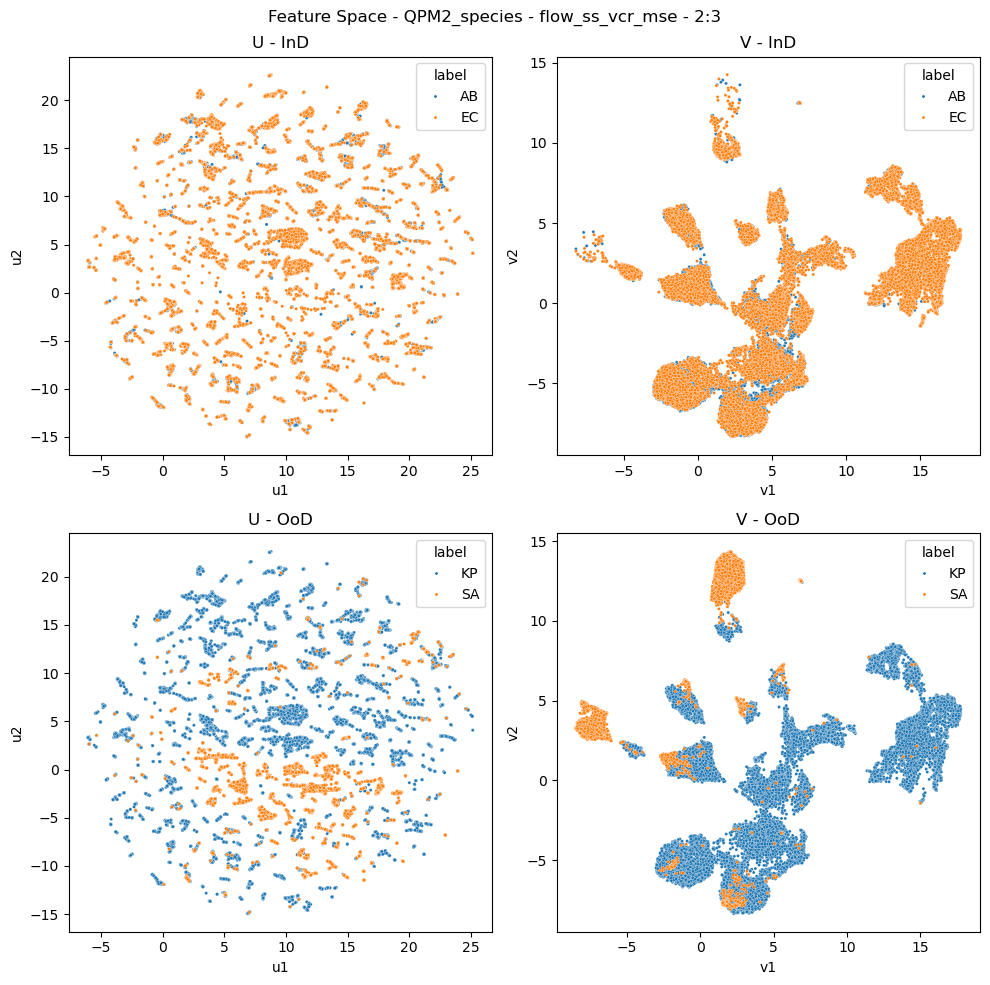

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

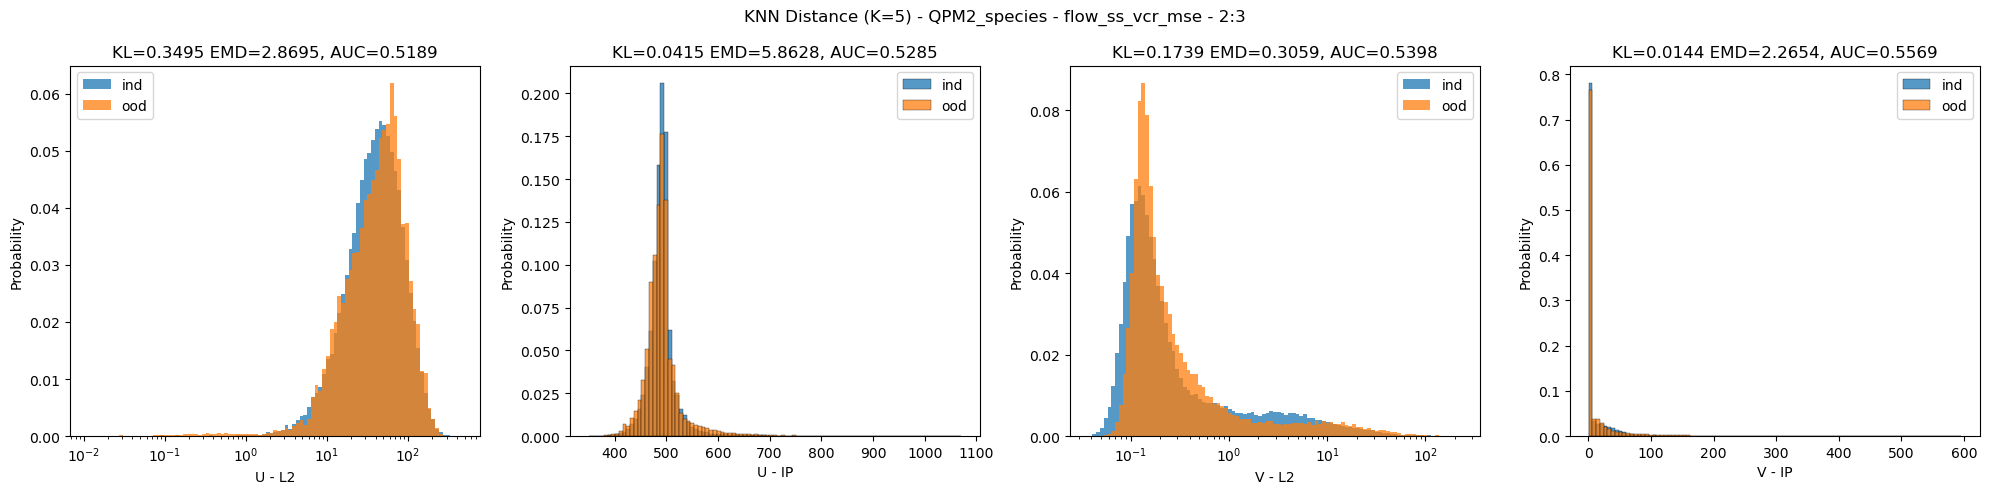

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

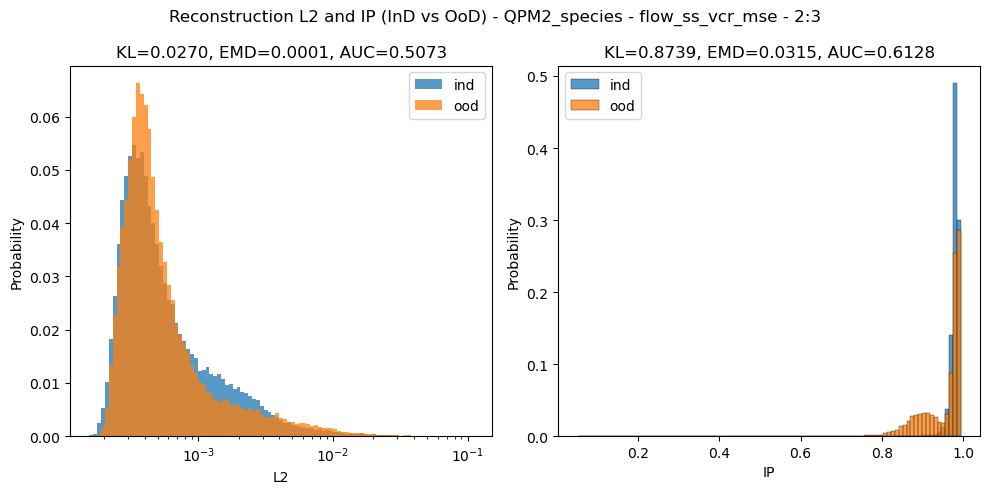

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.655027 0.46211573 1.4340844 1.6919682
22.6474 0.4609246 1.3971637 1.6640407
22.708471 0.5905987 1.4916514 1.9432033
22.713175 0.6986423 1.5599726 2.205481
32.845875 0.8779764 55.629044 0.7508357


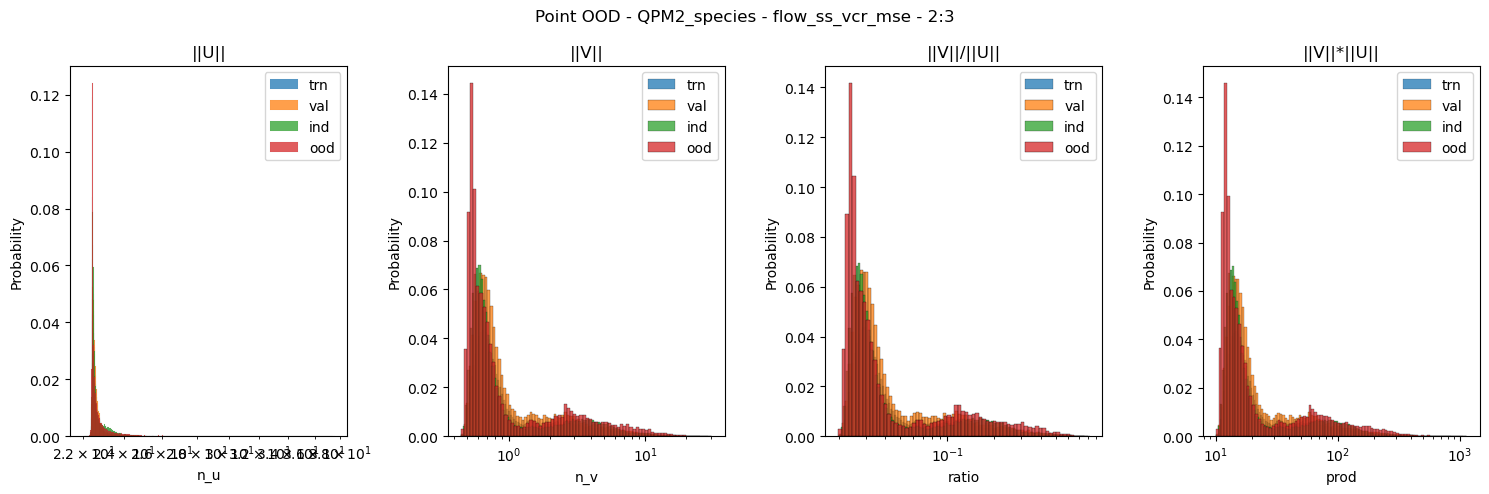

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


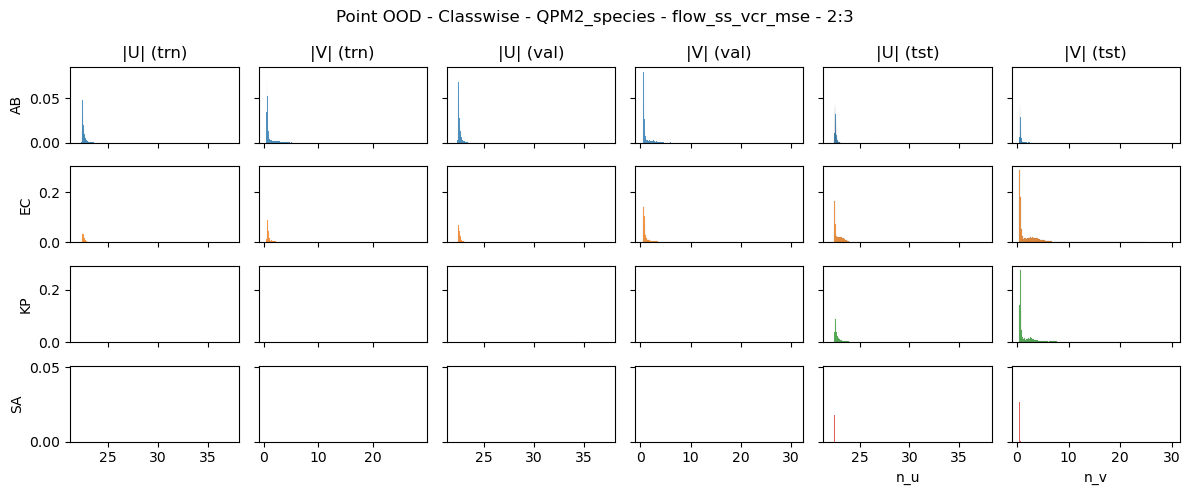

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

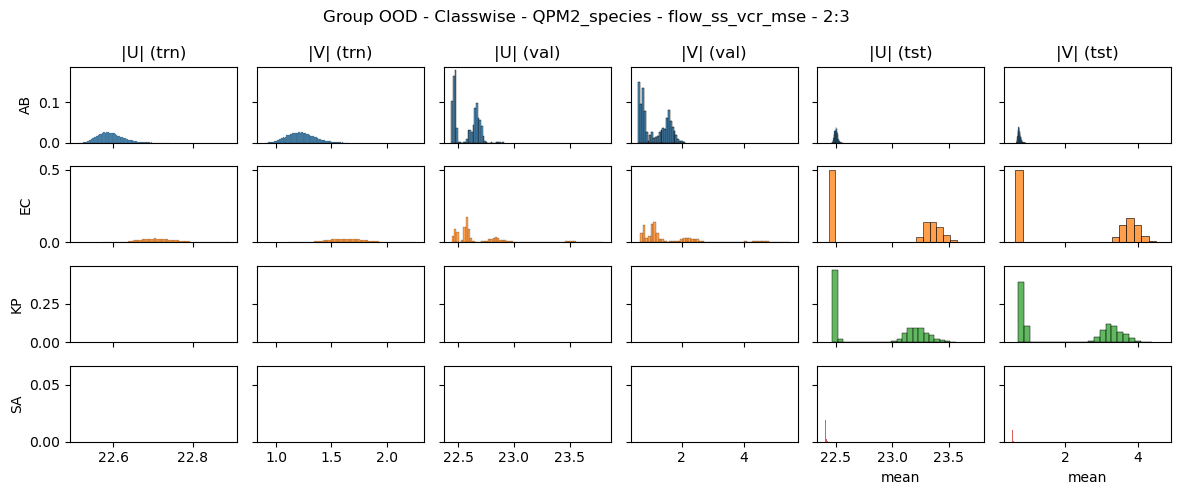

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)